In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from segmentflow import segment, view
from skimage import measure
%load_ext autoreload
%autoreload 2

Developed from mhe-analysis NB 36

In [60]:
plt.rcParams["font.family"] = "monospace"
def get_dims_df(imgs_labeled):
    # Format segmented data
    dims_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    dims_df = dims_df.rename(columns={'area' : 'volume'})
    # Calculate nslices by subtracting z min from max
    dims_df['nslices'] = (
        dims_df['bbox-3'].to_numpy() - dims_df['bbox-0'].to_numpy())
    # Calculate nrows by subtracting y min from max
    dims_df['nrows'] = (
        dims_df['bbox-4'].to_numpy() - dims_df['bbox-1'].to_numpy())
    # Calculate ncols by subtracting x min from max
    dims_df['ncols'] = (
        dims_df['bbox-5'].to_numpy() - dims_df['bbox-2'].to_numpy())
    return dims_df

def simulate_sieve(dims_df, bin_edges, pixel_res):
    # Define dimensions a, b, c with a as largest and c as smallest
    dims_df['a'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[0],
        axis=1
    )
    dims_df['b'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[1],
        axis=1
    )
    dims_df['c'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[2],
        axis=1
    )
    # Apply pixel resolution to second smallest dimension
    b_ums = pixel_res * dims_df['b'].to_numpy()
    n_particles, sieve_sizes = np.histogram(b_ums, bins=bin_edges)
    return n_particles, sieve_sizes

def grading_curve(
    n_particles, sieve_sizes, standard_pct=None, standard_label='Standard'
):
    n_particles = np.insert(n_particles, 0, 0)
    # seg_pct = 100 * seg_hist / dims_df.shape[0]
    pct_particles = 100 * n_particles / np.sum(n_particles)
    # Plot histogram
    fig, ax = plt.subplots(
        figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
    # ax.scatter(diameter_ums, np.cumsum(f50_pct), s=10, zorder=3)
    # ax.plot(
    #     diameter_ums, np.cumsum(f50_pct), linewidth=2, zorder=3, label='F50 Standard')
    # Plot segmented particle size distributions
    # seg_i_pct = sieve_df[f'seg-aspect-pct'].to_numpy()
    # seg_i_pct_cum = np.cumsum(seg_i_pct)
    # print(f'{sieve_sizes=}')
    # print(f'{np.cumsum(pct_particles)=}')
    ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2)
    ax.plot(
        sieve_sizes, np.cumsum(pct_particles), label='Segmented',
        linewidth=1, zorder=2
    )
    if standard_pct is not None:
        standard_pct = np.insert(standard_pct, 0, 0)
        # print(f'{sieve_sizes=}')
        # print(f'{standard_pct=}')
        ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
        ax.plot(
            sieve_sizes, standard_pct, label=standard_label,
            linewidth=1, zorder=2
        )
    ax.set_title('Segmented Particle Size Distribution by Aspect Ratio')
    ax.set_ylabel(r'Retained (%)')
    ax.set_ylim([0, 111])
    ax.set_xlabel('Particle diameter ($\mu m$)')
    # ax.set_xscale('log')
    ax.grid(True, axis='y', zorder=0)
    ax.set_xticks(sieve_sizes)
    ax.set_xticklabels(sieve_sizes)
    ax.legend(loc='lower right', ncol=1)
    return fig, ax

## Plot STL-0 Size Distribution

In [3]:
csv_path = Path(
    r'C:\Users\cgusb\Research\PSAAP\alshibli_1551_study'
    r'\alshibli-1551-bounds.csv')
dims_df = pd.read_csv(csv_path)
dims_df.head()

,x_min,y_min,z_min,x_max,y_max,z_max,filename,nslices,nrows,ncols
0,1100.626221,1962.473877,9.454297,1232.025391,2083.570557,155.095642,P1,145.641345,121.096680,131.399170
1,1947.992554,2183.382324,14.656619,2126.827637,2369.646973,213.044571,P10,198.387952,186.264648,178.835083
2,3086.012695,1167.215088,143.818481,3366.259766,1419.653809,463.213501,P100,319.395020,252.438721,280.247070
3,25.117933,1877.562256,1378.579712,299.455719,2205.922119,1712.898682,P1000,334.318970,328.359863,274.337786
4,2468.705322,1687.952271,1382.988037,2758.225830,1947.786255,1566.749023,P1001,183.760986,259.833984,289.520508


In [4]:
dims_df.iloc[0]['nslices' : 'ncols'].astype(int).nlargest(3).iloc[1]

131

sieve_sizes=[53, 75, 106, 150, 212, 300, 425, 600, 850]
np.cumsum(pct_particles)=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])
sieve_sizes=[53, 75, 106, 150, 212, 300, 425, 600, 850]
standard_pct=array([  0. ,   0.2,   3.2,  18.2,  55.2,  89.2,  99.7, 100. , 100. ])
stl0_cum_pct=array([  1.16054159,   4.12637008,  13.34622824,  33.52675693,
        65.95744681,  96.77627337, 100.        , 100.        ])


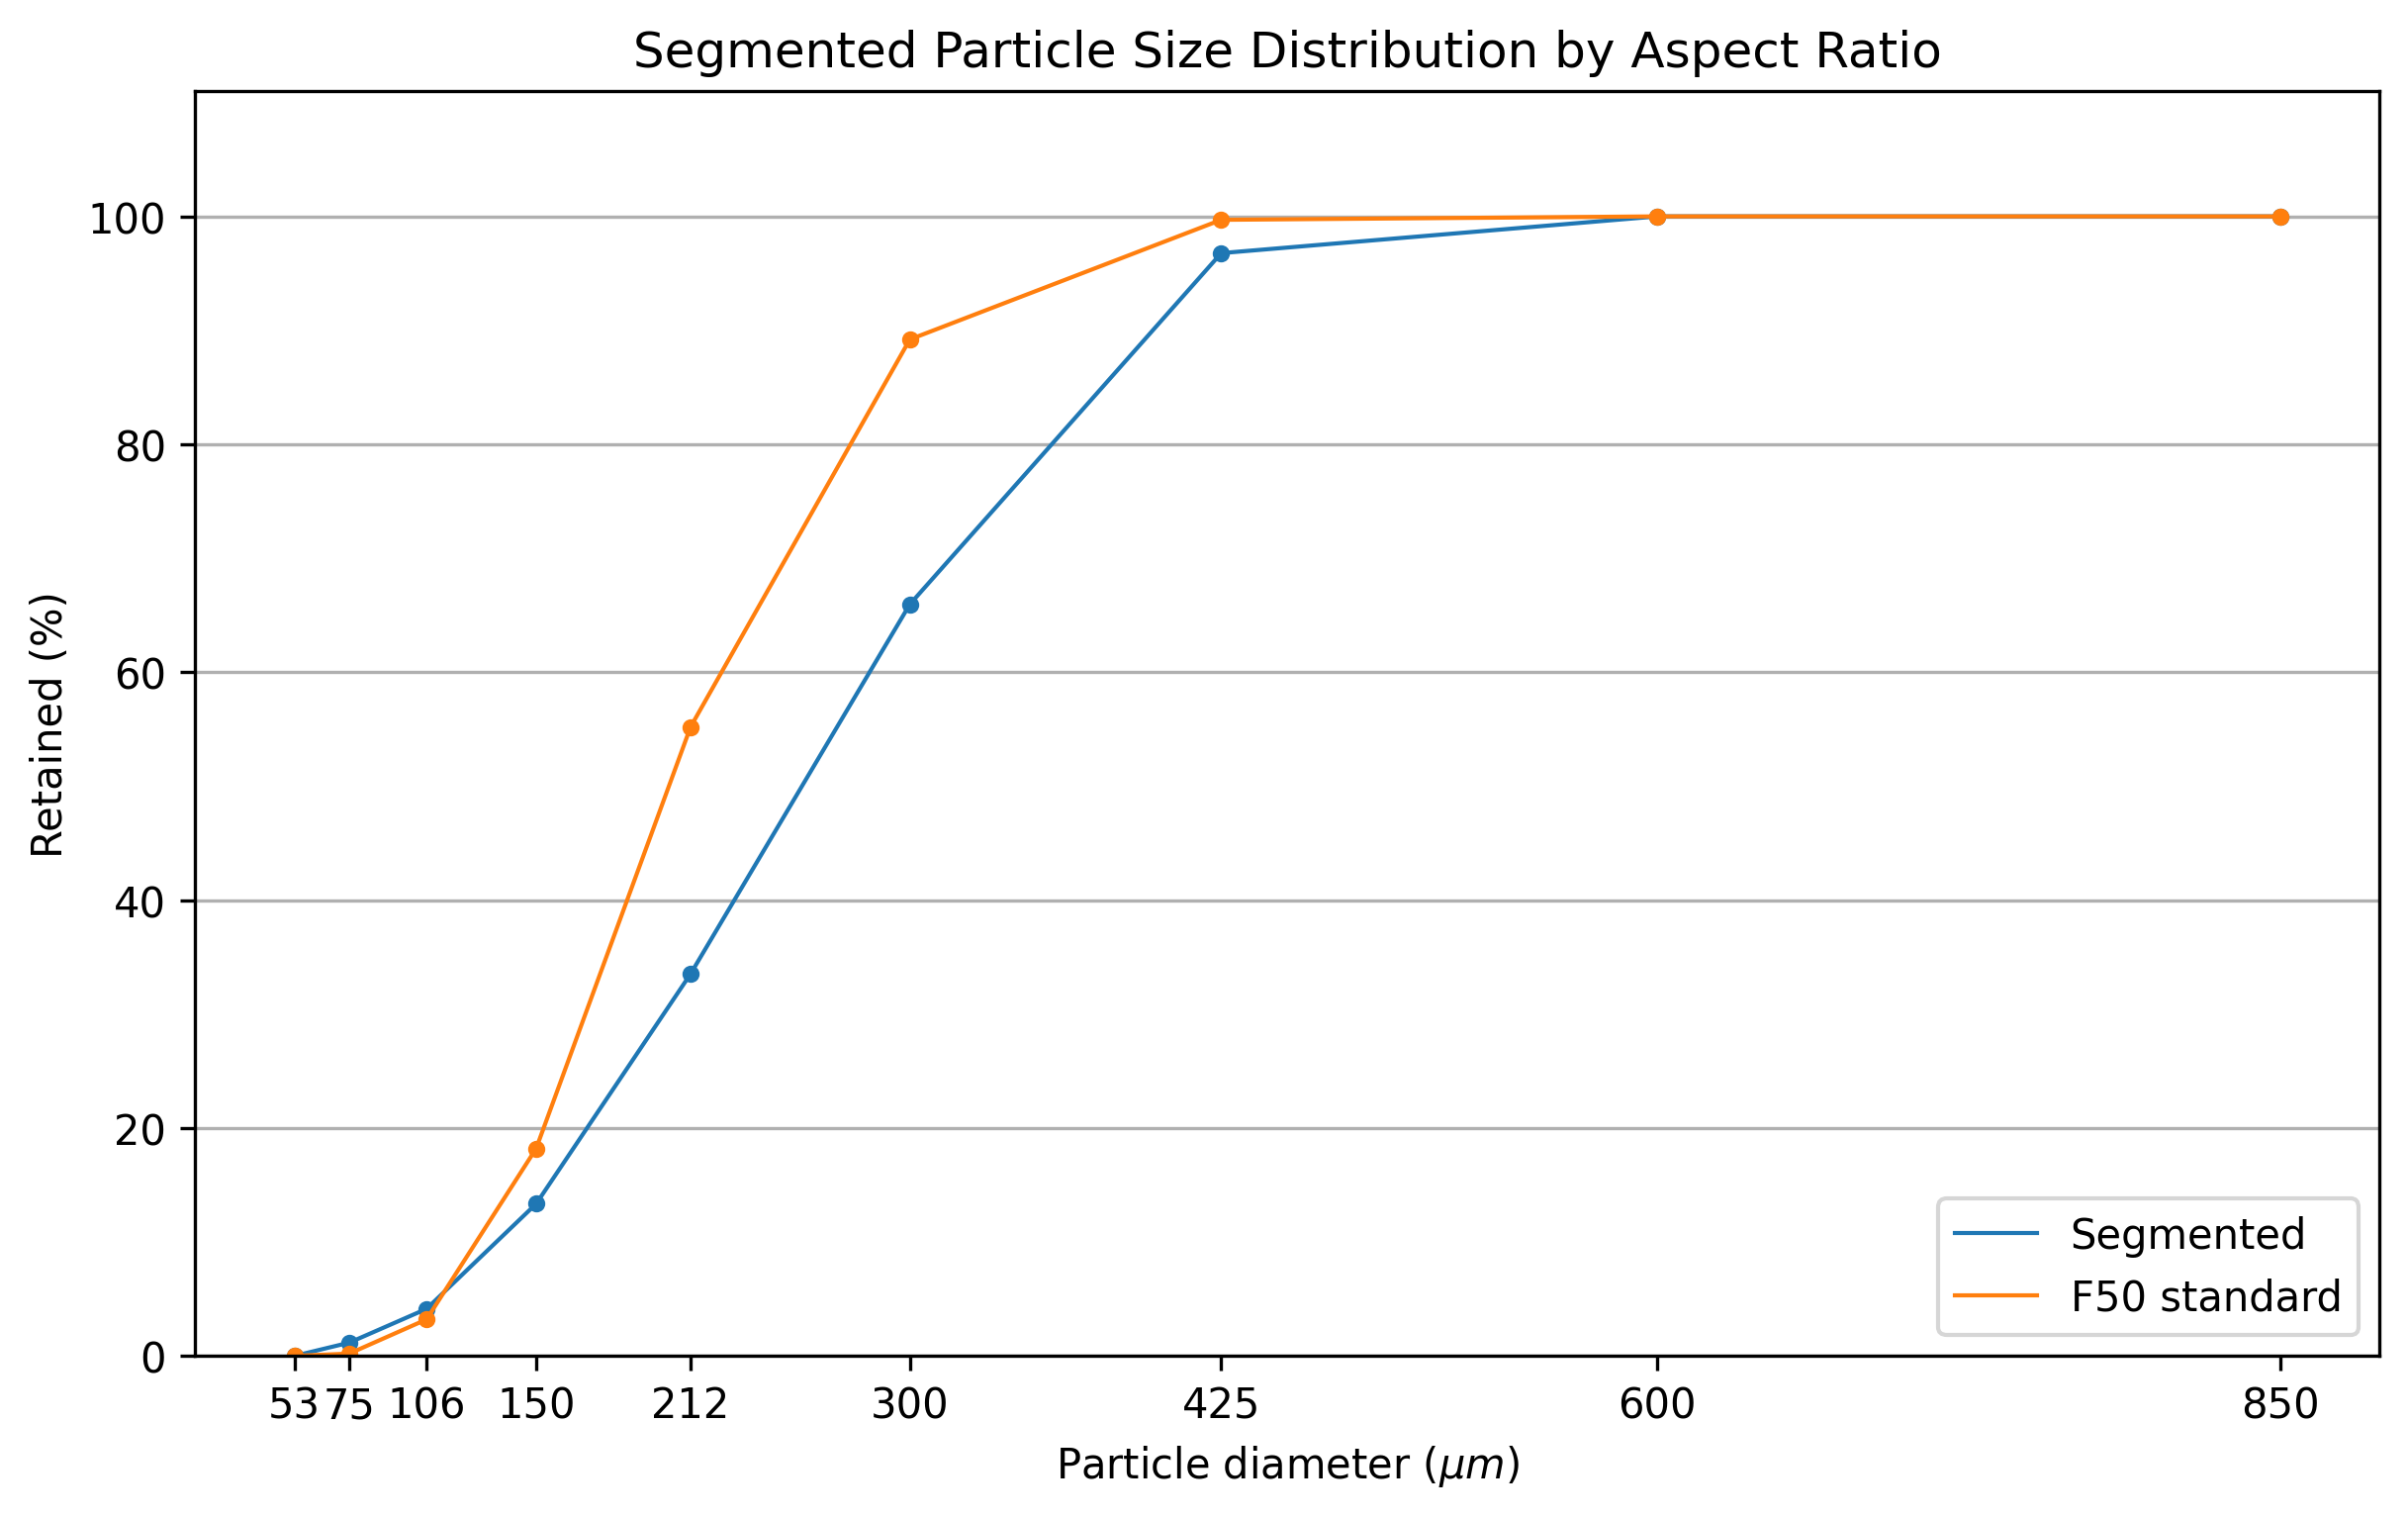

In [5]:
f50_bin_edges = [53,  75, 106, 150, 212, 300,  425, 600, 850]
f50_standard =  [0.2,   3,  15,  37,  34, 10.5, 0.3,   0]
# ct_res = 2.02  # ums/voxels
csv_path = Path(
    r'C:\Users\cgusb\Research\PSAAP\alshibli_1551_study'
    r'\alshibli-1551-bounds.csv')
dims_df = pd.read_csv(csv_path)
stl0_n_particles, sieve_sizes = simulate_sieve(
    dims_df, f50_bin_edges, pixel_res=1)
fig, ax = grading_curve(
    stl0_n_particles, f50_bin_edges, standard_pct=np.cumsum(f50_standard),
    standard_label='F50 standard')
stl0_pct_particles = 100 * stl0_n_particles / np.sum(stl0_n_particles)
stl0_cum_pct = np.cumsum(stl0_pct_particles)
print(f'{stl0_cum_pct=}')
plt.show()

## Outputs 10, 20, 40, 80

CT resolution: 294.3864
Loading images...
--> Images loaded as 3D array:  (10, 15, 15)


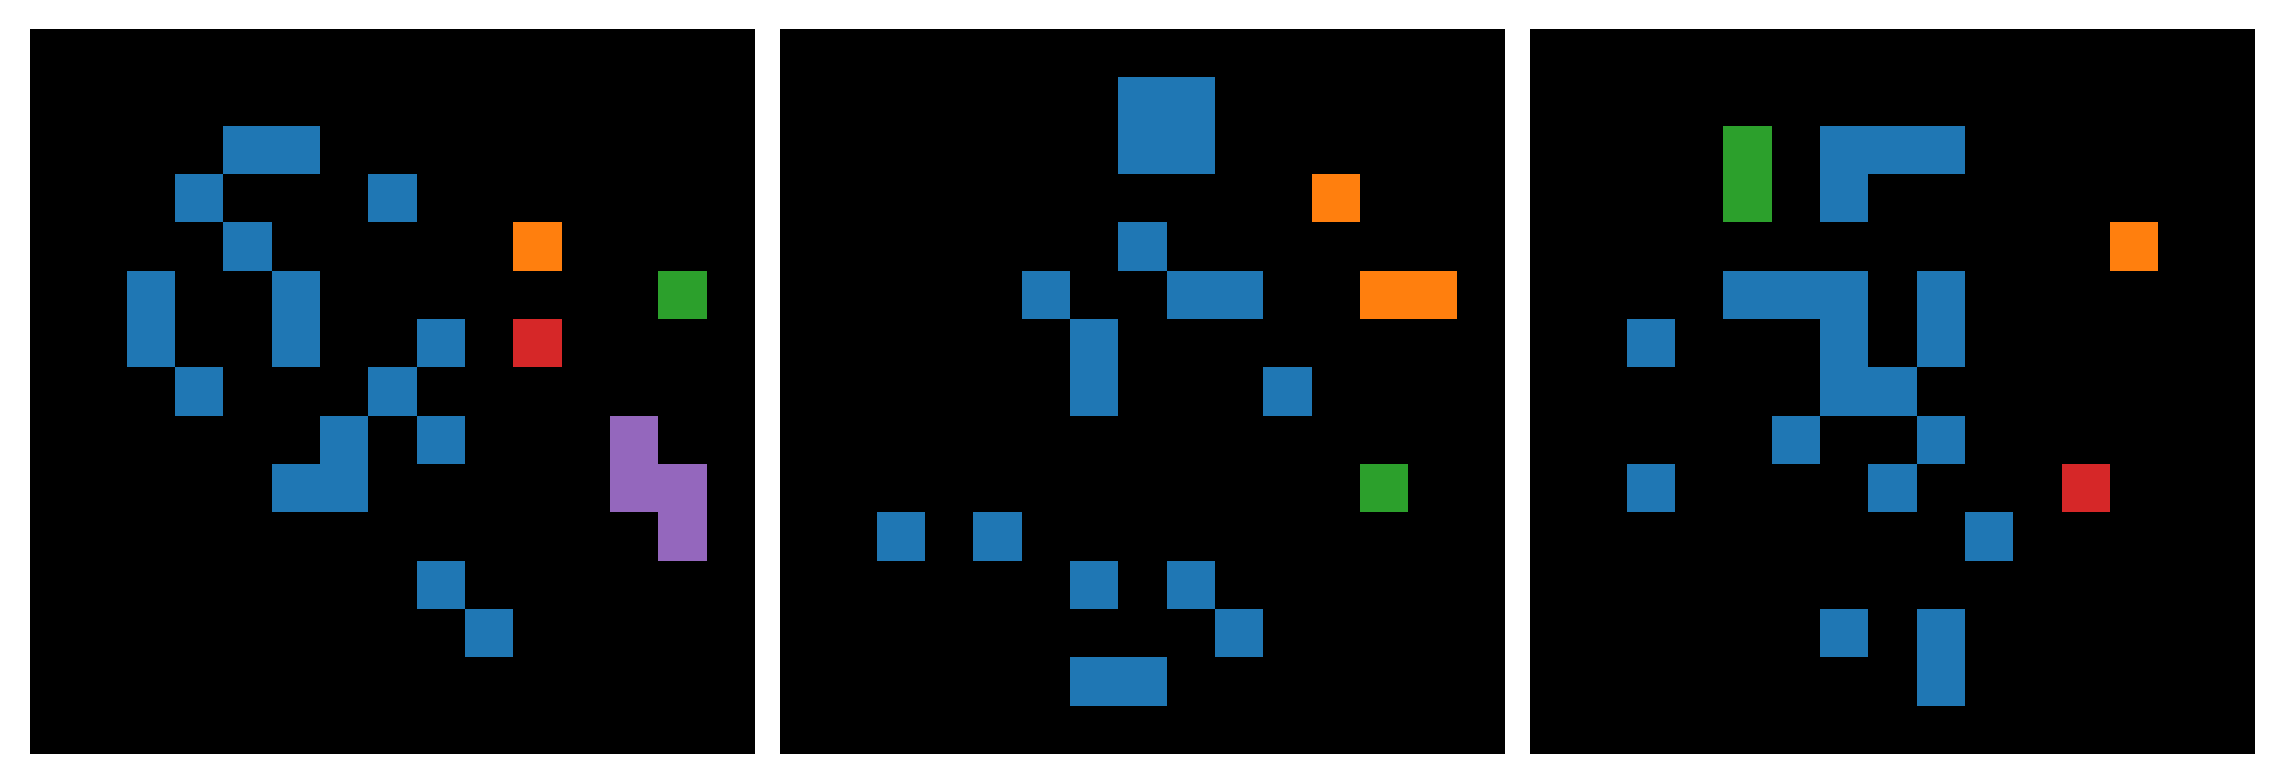

CT resolution: 147.1932
Loading images...
--> Images loaded as 3D array:  (20, 30, 30)


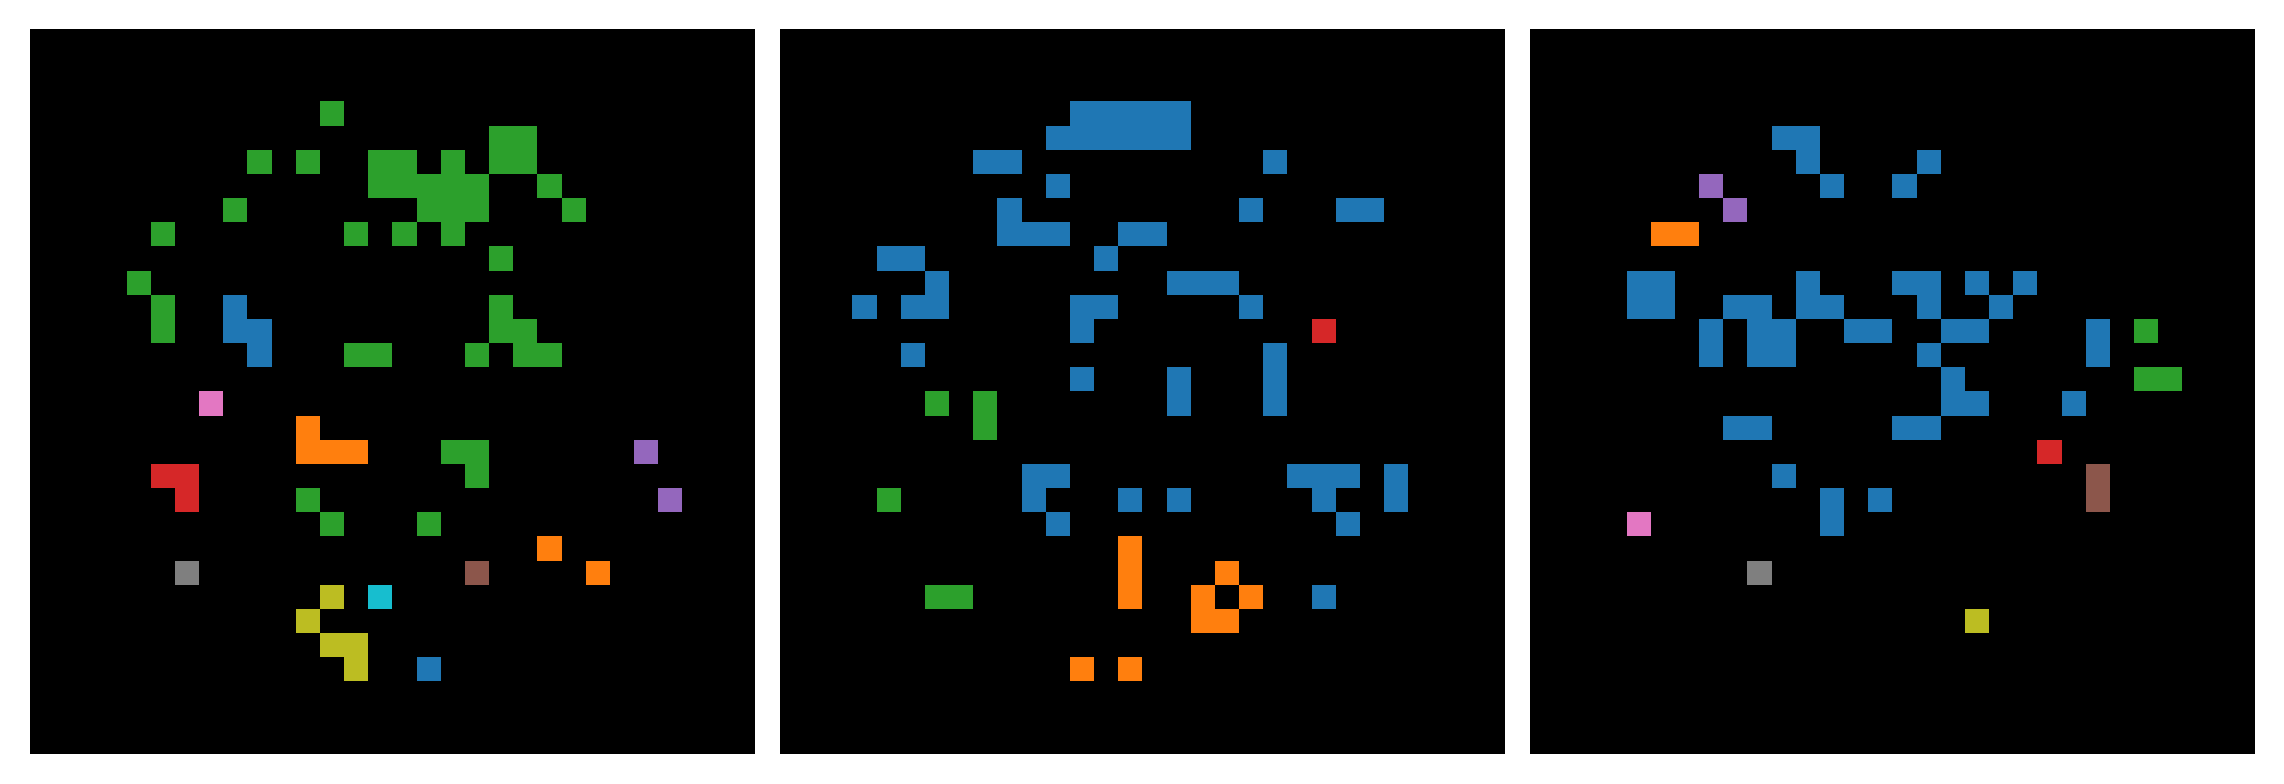

CT resolution: 73.5966
Loading images...
--> Images loaded as 3D array:  (40, 60, 60)


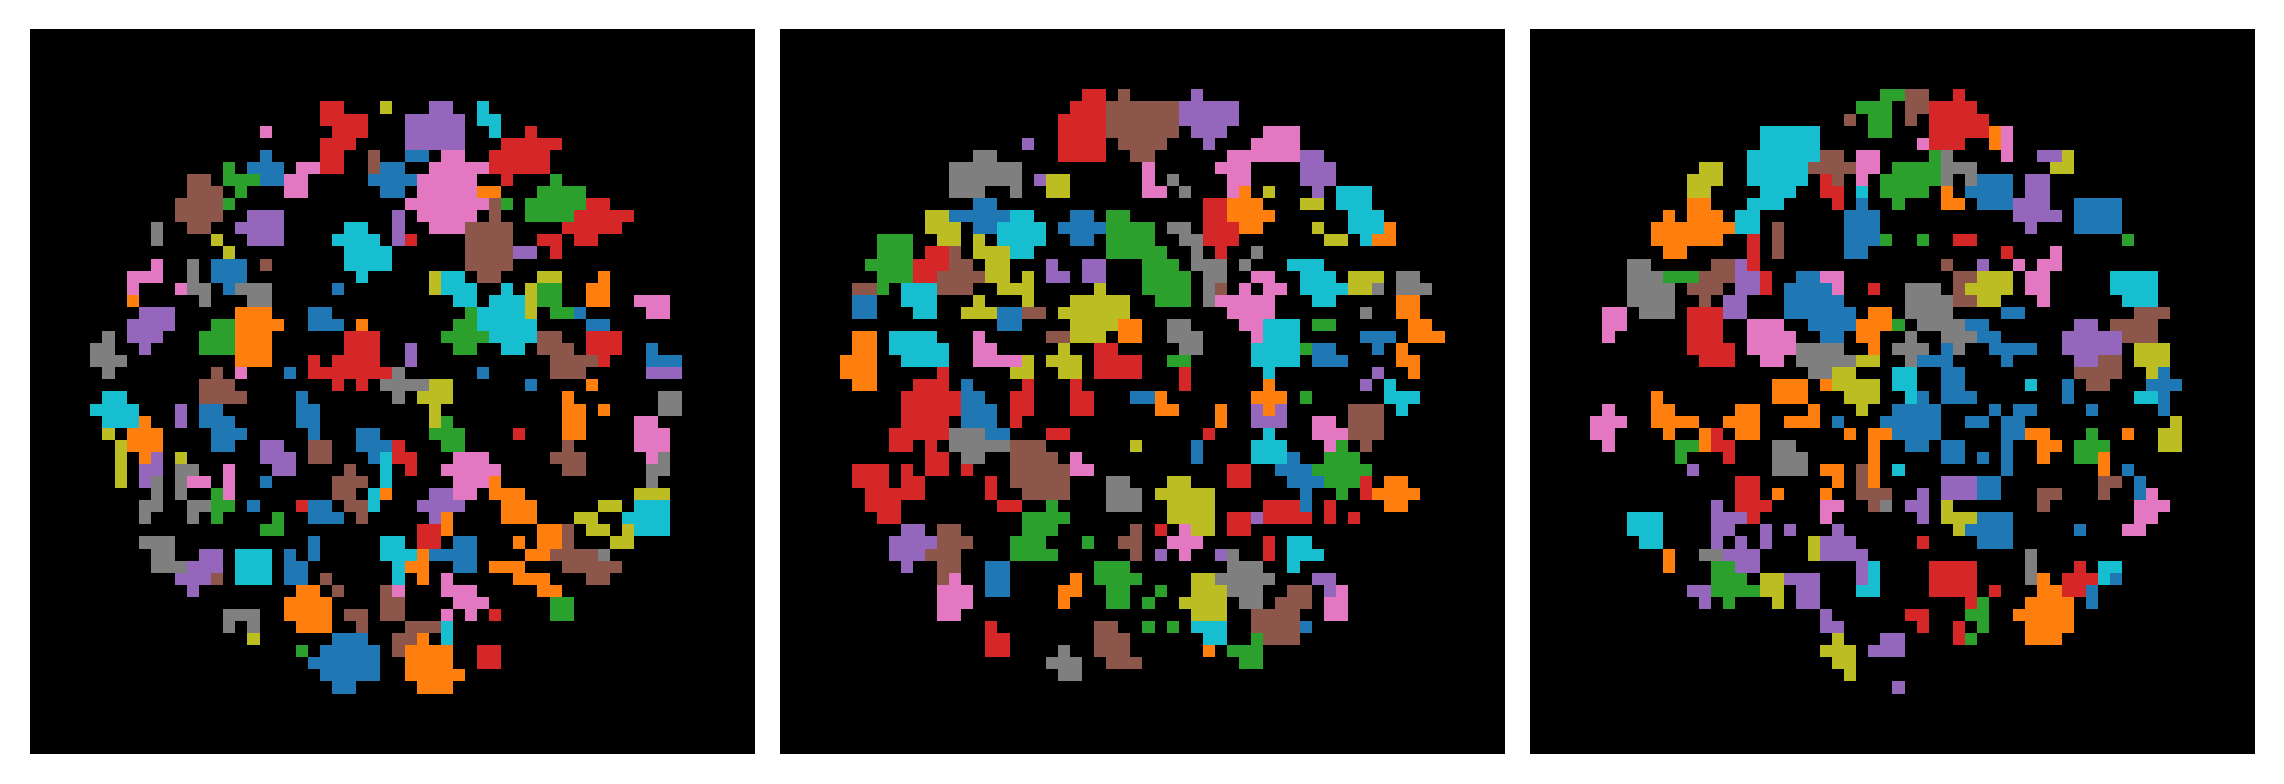

CT resolution: 36.7983
Loading images...
--> Images loaded as 3D array:  (80, 120, 120)


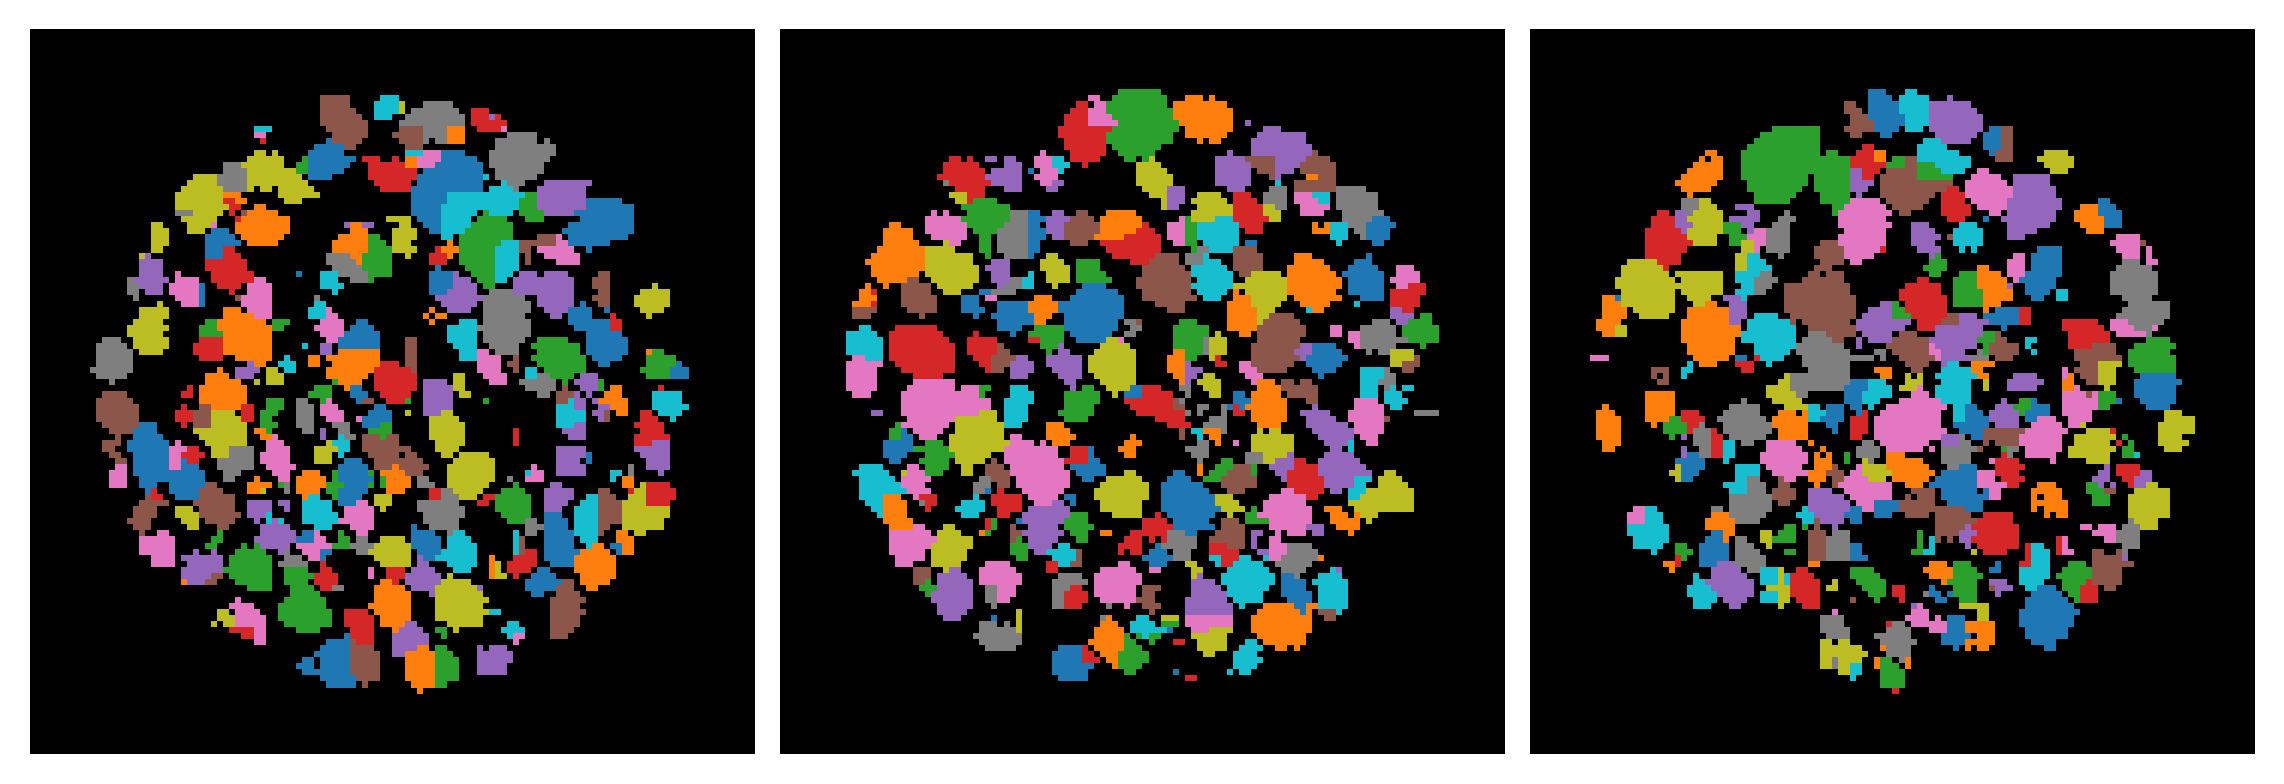

In [88]:
n_particles_dict = {}
resolutions = {
    10  : 294.3864,
    20  : 147.1932,
    40  : 73.5966,
    80  : 36.7983,
    # 160 : 18.39915,
    # 320 : 9.199575,
}
for n_grid_voxels, ct_res in resolutions.items():
    print('CT resolution:', ct_res)
    # img_dir_path = Path(
    #     f'segmentflow_output/output_{str(n_grid_voxels).zfill(3)}'
    #     f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    img_dir_path = Path(
        f'C:/Users/cgusb/Research/PSAAP/alshibli_1551_study/'
        f'segmentflow_output/output_{str(n_grid_voxels).zfill(3)}'
        f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    imgs_labeled = segment.load_images(img_dir_path, file_suffix='tif')
    fig, axes = view.plot_color_labels(
        imgs_labeled, nslices=3, exclude_bounding_slices=True, fig_w=7.5,
        dpi=300
    )
    # Based on IDOX "Full Production" doc
    # idox_bin_edges = np.array([0, 45, 75, 150, 300])
    # idox_standard = [33, 17, 0, 47.5]
    dims_df = get_dims_df(imgs_labeled)
    n_particles, sieve_sizes = simulate_sieve(
        dims_df, f50_bin_edges, pixel_res=ct_res)
    n_particles_dict[n_grid_voxels] = n_particles
    # fig, ax = grading_curve(
    #     n_particles, f50_bin_edges, standard_pct=stl0_cum_pct,
    #     standard_label='STL-0')
    plt.show()

## Output 160, MPD 1 - 3

Minimum peak distance: 1
CT resolution: 18.39915
Minimum peak distance (um): 18.39915
Loading images...
--> Images loaded as 3D array:  (160, 240, 240)


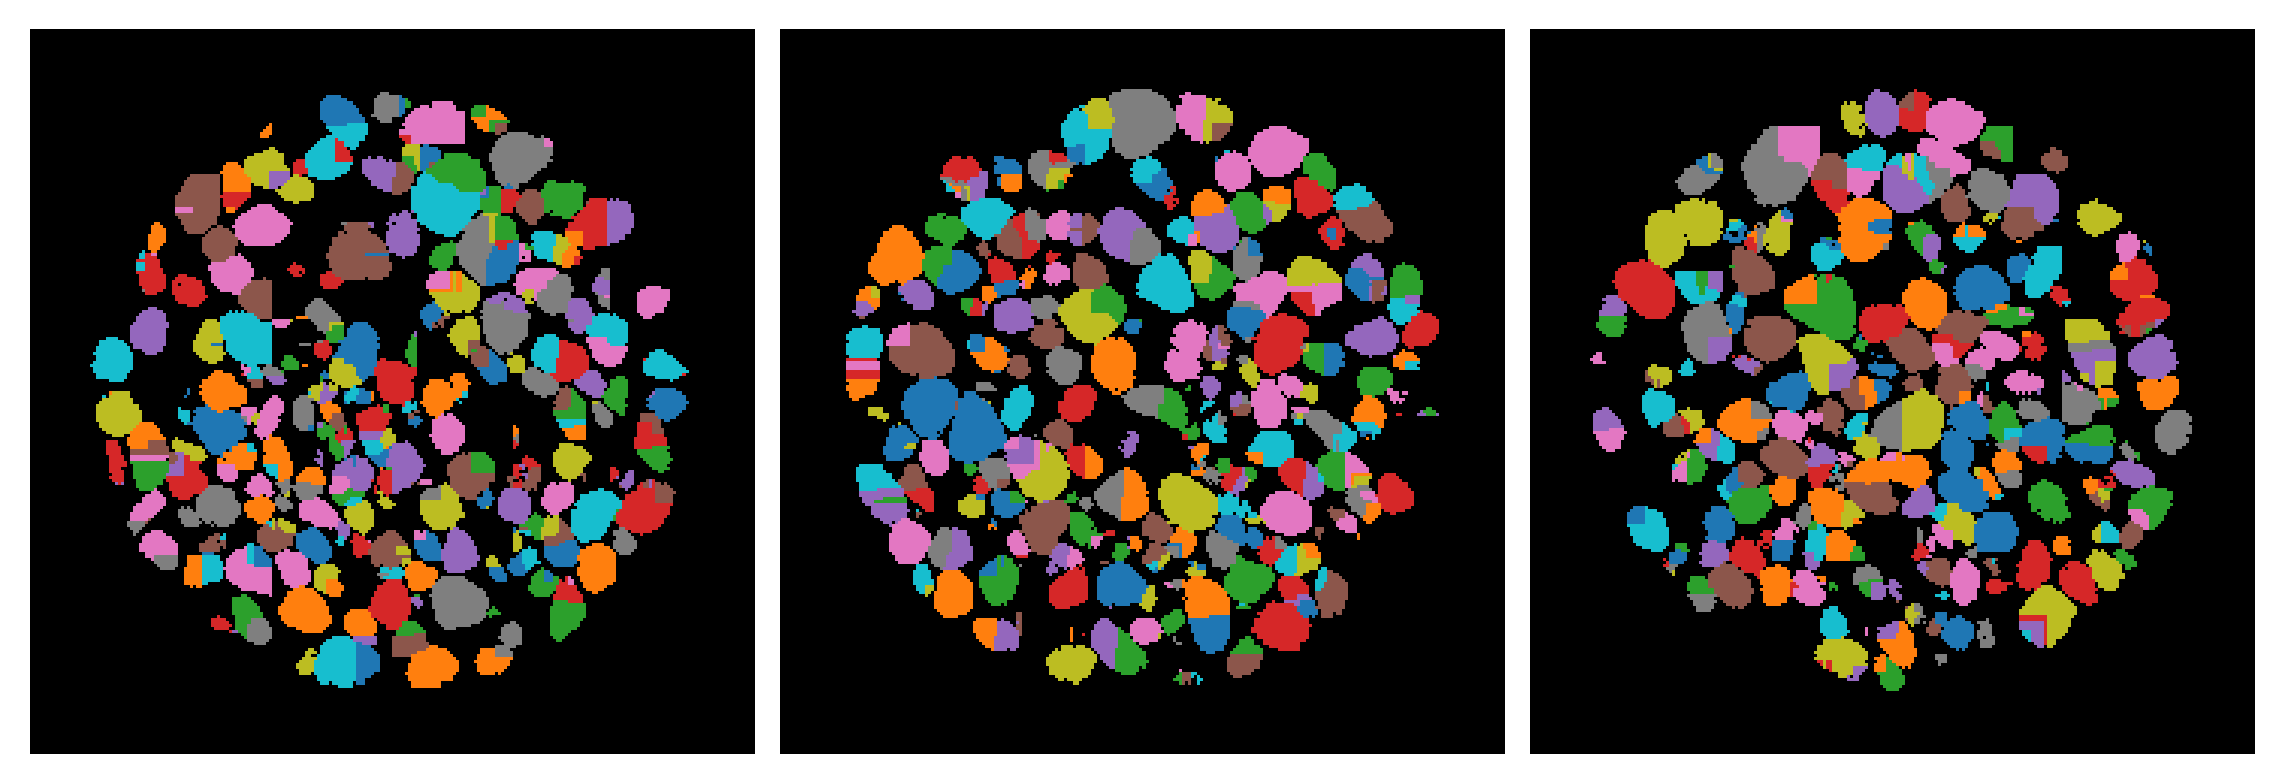

Minimum peak distance: 2
CT resolution: 18.39915
Minimum peak distance (um): 36.7983
Loading images...
--> Images loaded as 3D array:  (160, 240, 240)


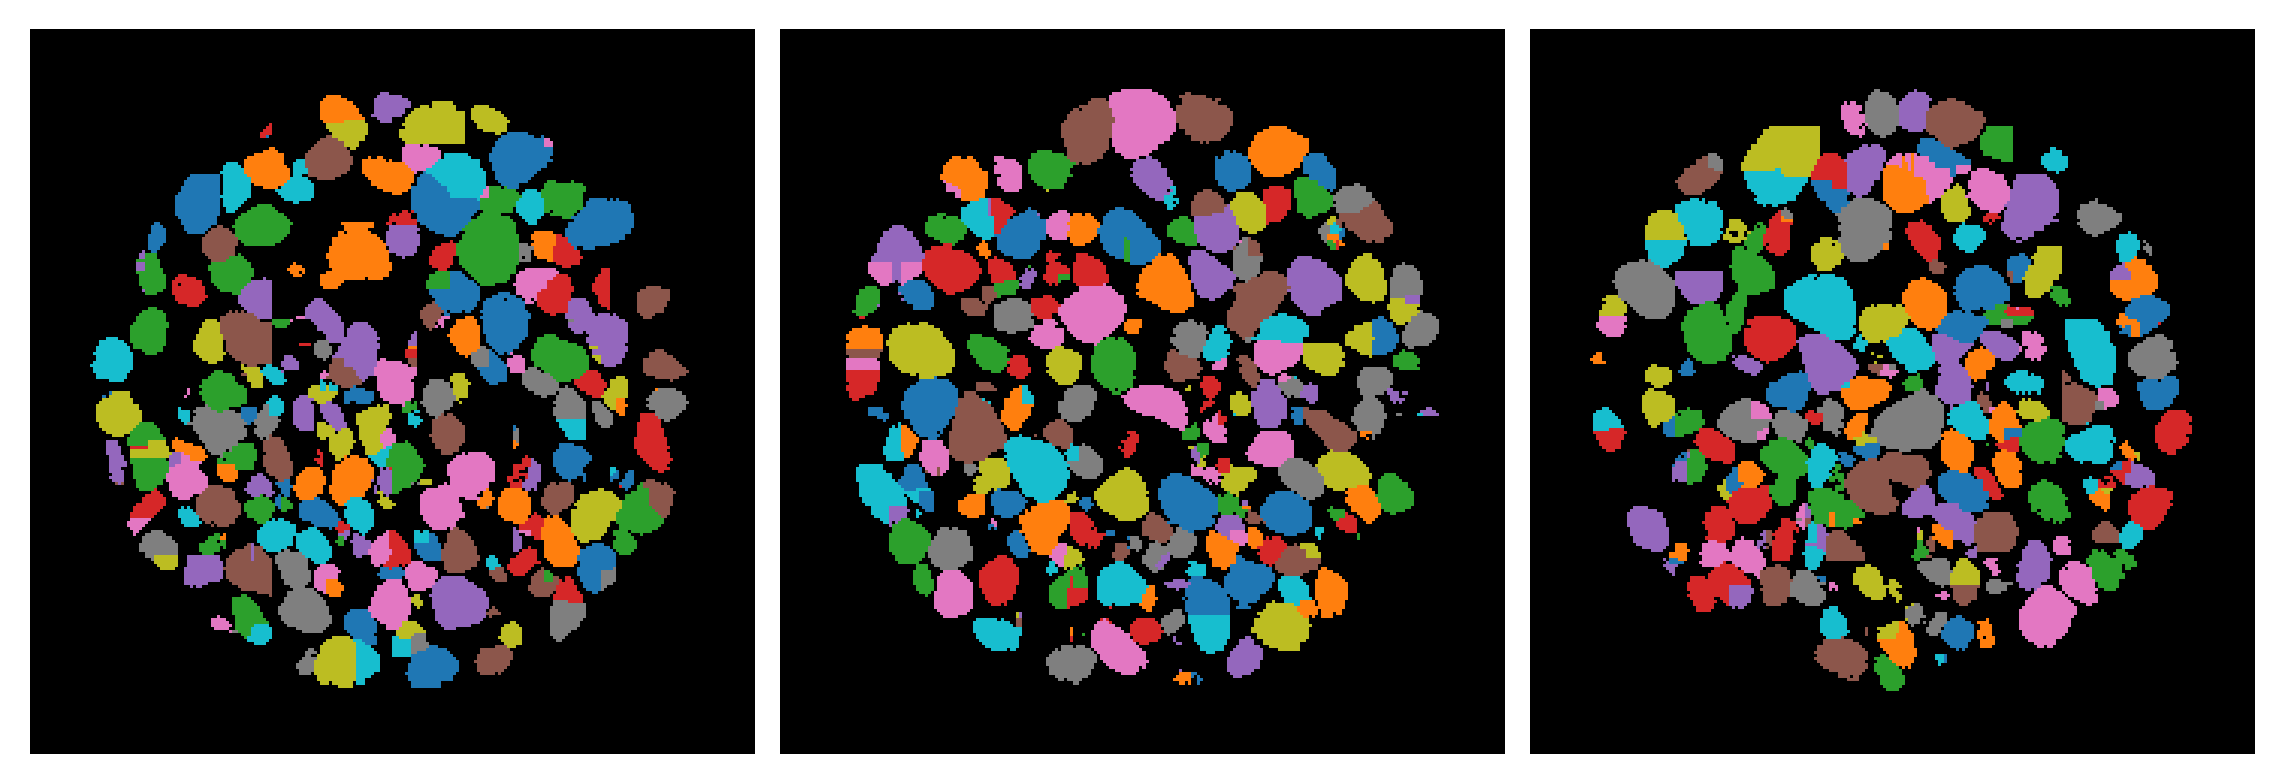

Minimum peak distance: 3
CT resolution: 18.39915
Minimum peak distance (um): 55.197449999999996
Loading images...
--> Images loaded as 3D array:  (160, 240, 240)


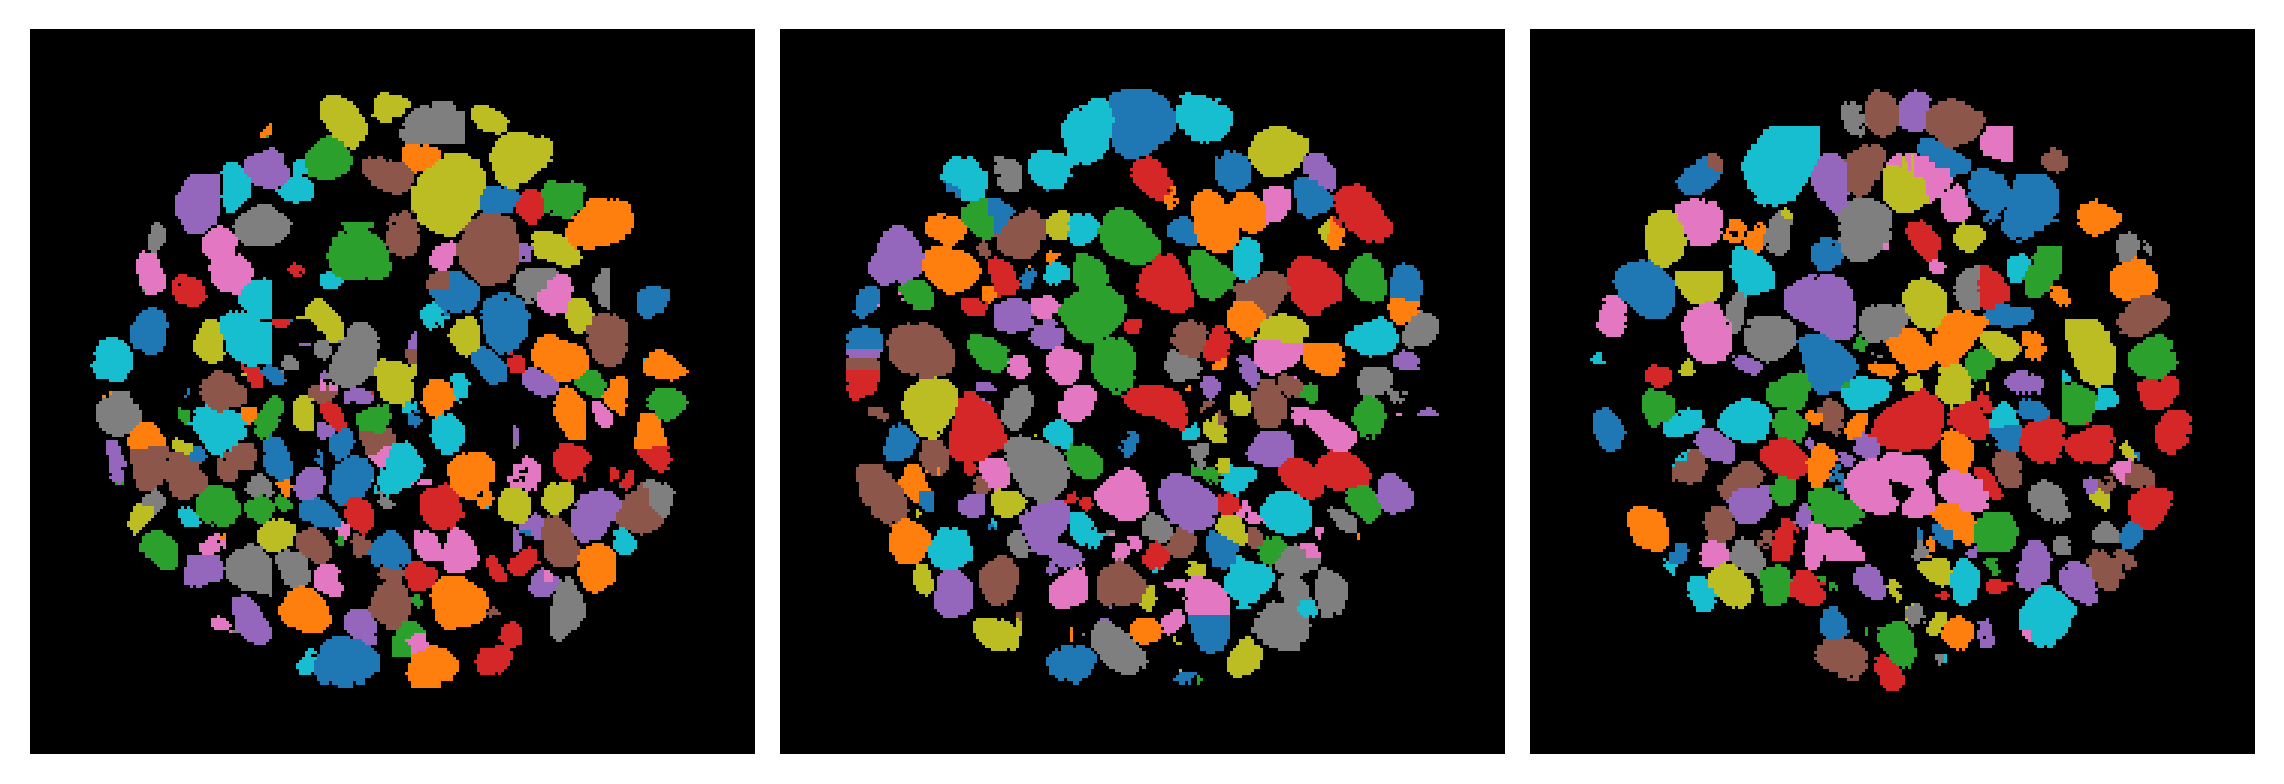

In [95]:
n_grid_voxels = 160
ct_res = 18.39915
for mpd in range(1, 4):
    print('Minimum peak distance:', mpd)
    print('CT resolution:', ct_res)
    print('Minimum peak distance (um):', mpd * ct_res)
    # img_dir_path = Path(
    #     f'segmentflow_output/output_{str(n_grid_voxels).zfill(3)}_{mpd}mpd'
    #     f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    img_dir_path = Path(
        f'C:/Users/cgusb/Research/PSAAP/alshibli_1551_study'
        f'/segmentflow_output/output_{str(n_grid_voxels).zfill(3)}_{mpd}mpd'
        f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    imgs_labeled = segment.load_images(img_dir_path, file_suffix='tif')
    fig, axes = view.plot_color_labels(
        imgs_labeled, nslices=3, exclude_bounding_slices=True, fig_w=7.5,
        dpi=300
    )
    # Based on IDOX "Full Production" doc
    # idox_bin_edges = np.array([0, 45, 75, 150, 300])
    # idox_standard = [33, 17, 0, 47.5]
    f50_bin_edges = [53,  75, 106, 150, 212, 300,  425, 600, 850]
    f50_standard =  [ 0, 0.2,   3,  15,  37,  34, 10.5, 0.3,   0]
    dims_df = get_dims_df(imgs_labeled)
    n_particles, sieve_sizes = simulate_sieve(
        dims_df, f50_bin_edges, pixel_res=ct_res)
    n_particles_dict[f'{n_grid_voxels}_{mpd}mpd'] = n_particles
    # fig, ax = grading_curve(
    #     n_particles, f50_bin_edges, standard_pct=stl0_cum_pct,
    #     standard_label='STL-0')
    plt.show()

sieve_sizes=array([ 53,  75, 106, 150, 212, 300, 425, 600, 850])
standard_pct=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])


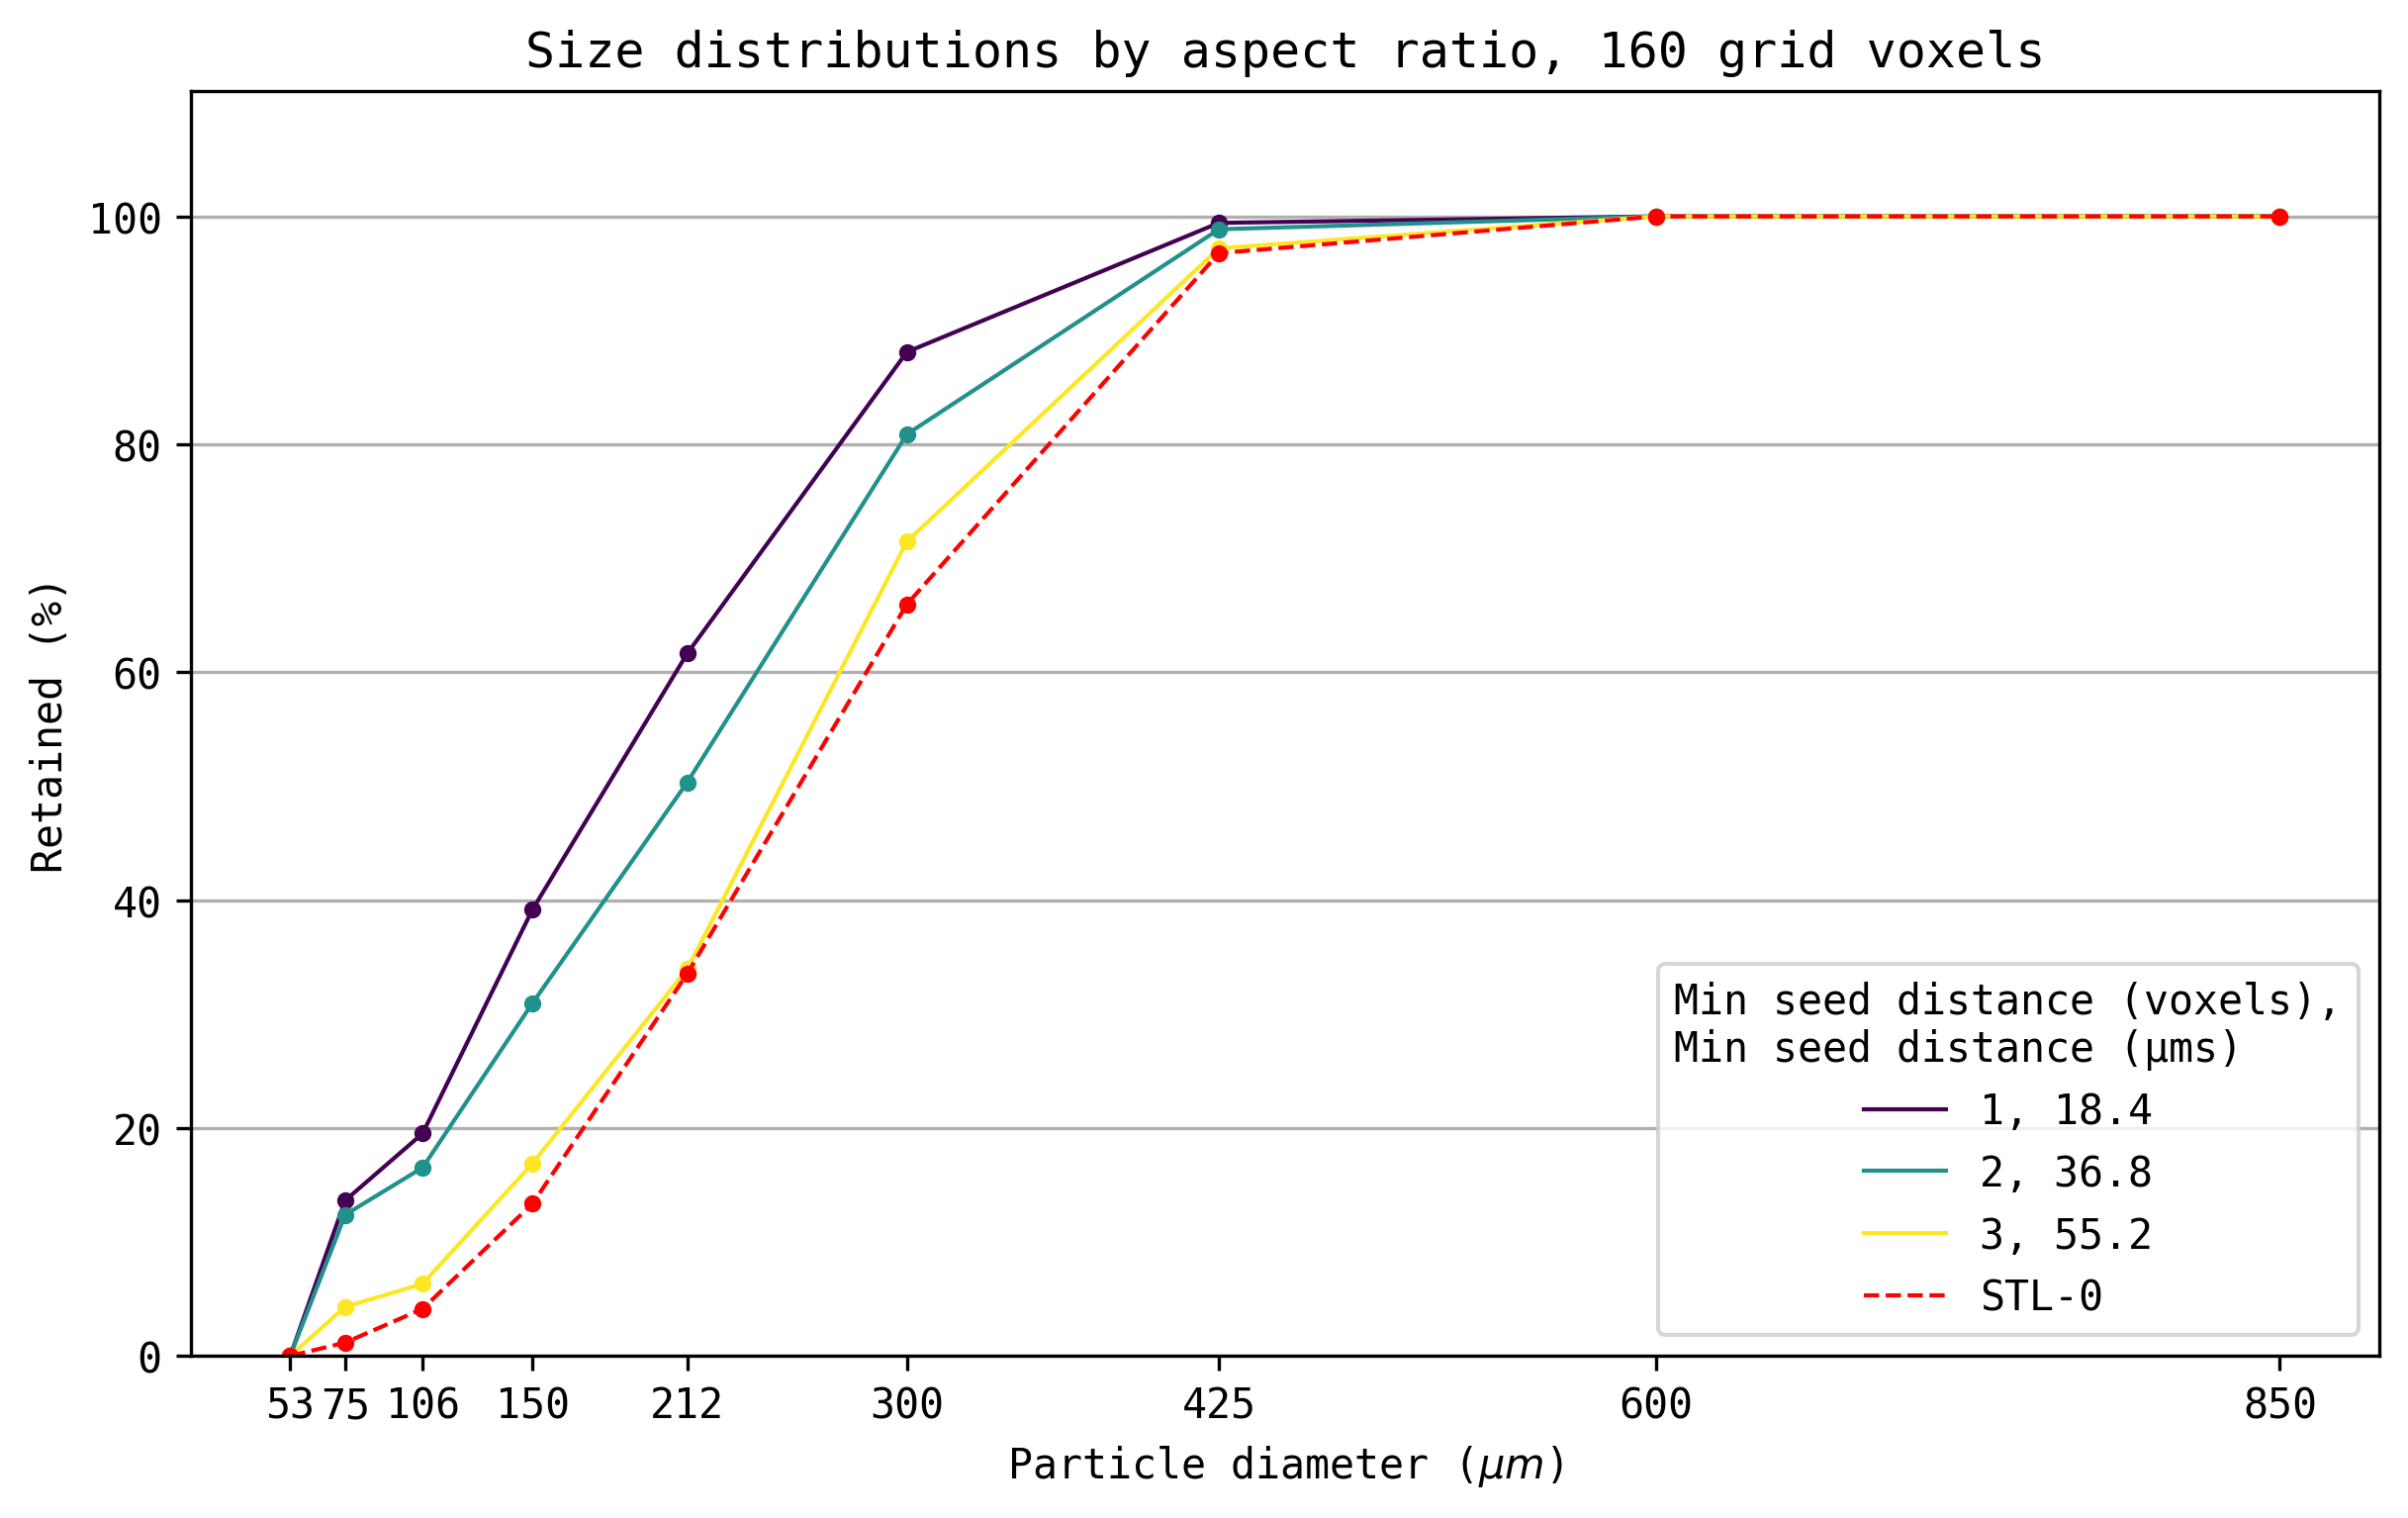

In [144]:
# Plot histogram
ct_res = 18.39915
to_plot = ['160_1mpd', '160_2mpd', '160_3mpd']
cmap = plt.get_cmap('viridis', len(to_plot))
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
i = 0
for label, n_particles in n_particles_dict.items():
    if label in to_plot:
        mpd = int(label[4])
        mpd_ums = mpd * ct_res
        n_particles = np.insert(n_particles, 0, 0)
        pct_particles = 100 * n_particles / np.sum(n_particles)
        ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2,
            color=cmap(i))
        ax.plot(
            sieve_sizes, np.cumsum(pct_particles),
            label=f'{mpd}, {round(mpd_ums, 1): >4}',
            linewidth=1, zorder=2, color=cmap(i)
        )
        i += 1
standard_pct = np.insert(stl0_cum_pct, 0, 0)
print(f'{sieve_sizes=}')
print(f'{standard_pct=}')
ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2, color='red')
ax.plot(
    sieve_sizes, standard_pct, label='STL-0',
    linewidth=1, zorder=2, color='red', linestyle='--'
)
ax.set_title('Size distributions by aspect ratio, 160 grid voxels')
ax.set_ylabel(r'Retained (%)')
ax.set_ylim([0, 111])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(sieve_sizes)
ax.set_xticklabels(sieve_sizes)
ax.legend(
    title='Min seed distance (voxels),\nMin seed distance (µms)',
    loc='lower right')
plt.show()

## Output 320, MPD 1 - 5

Minimum peak distance: 1
CT resolution: 9.199575
Minimum peak distance (um): 9.199575
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


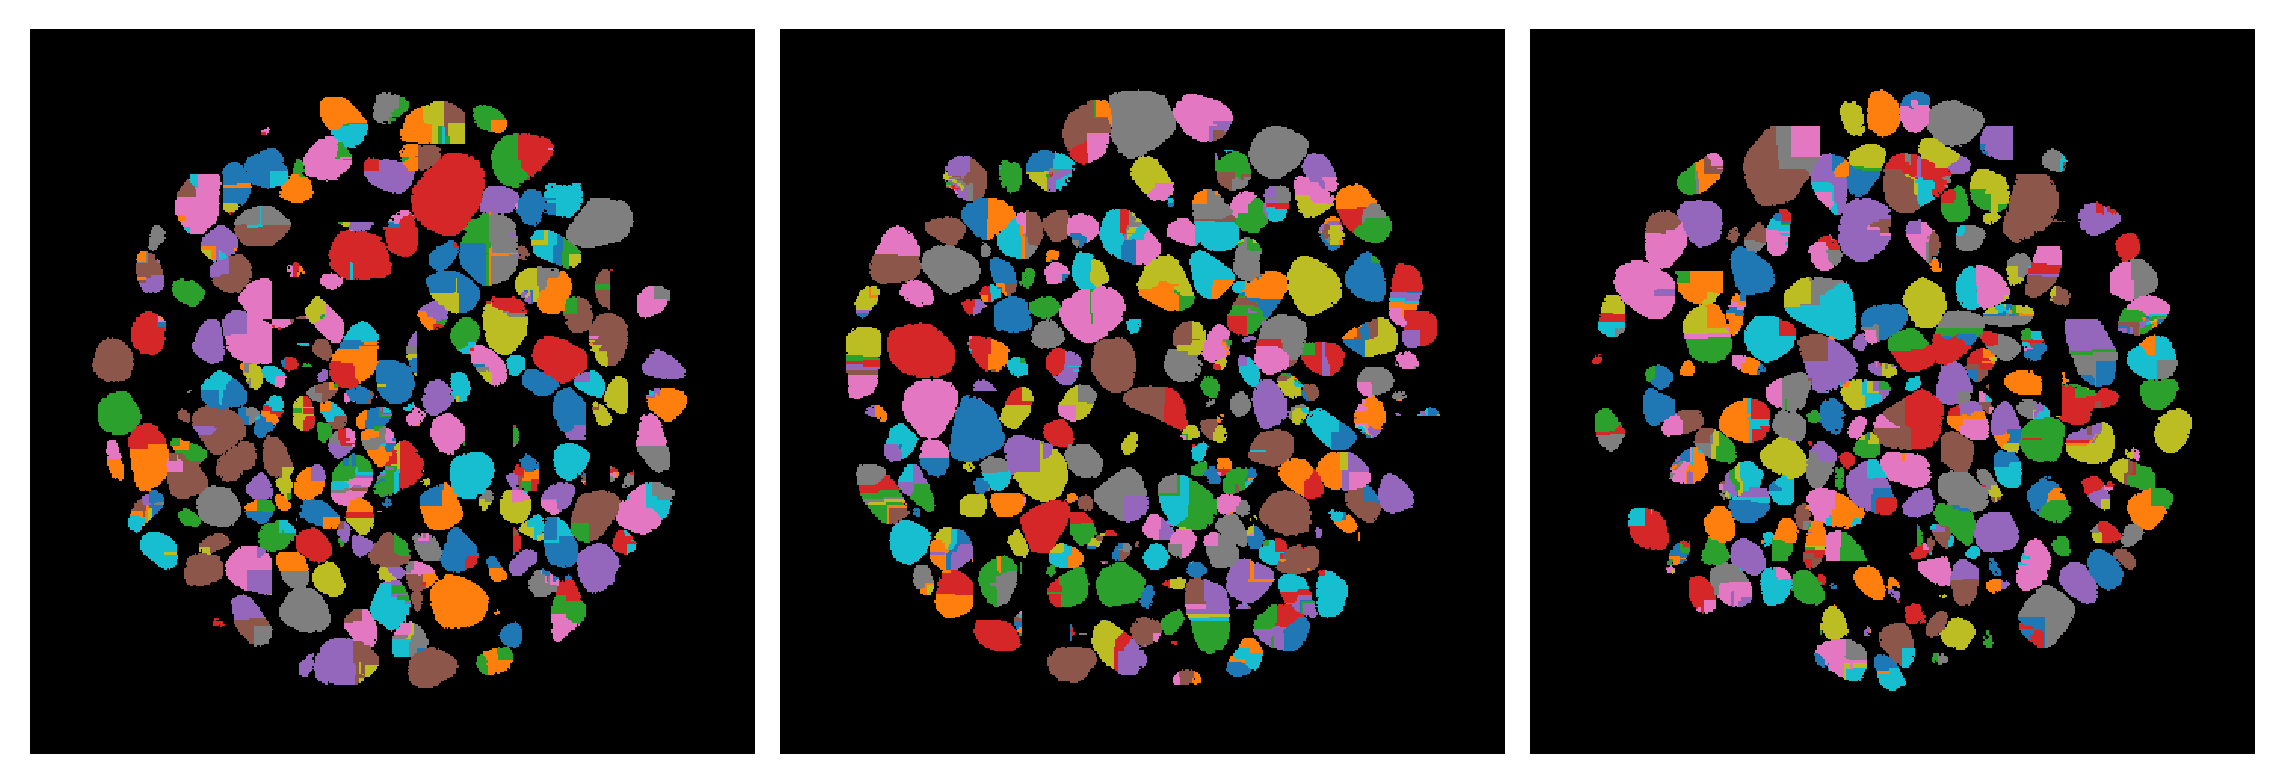

Minimum peak distance: 2
CT resolution: 9.199575
Minimum peak distance (um): 18.39915
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


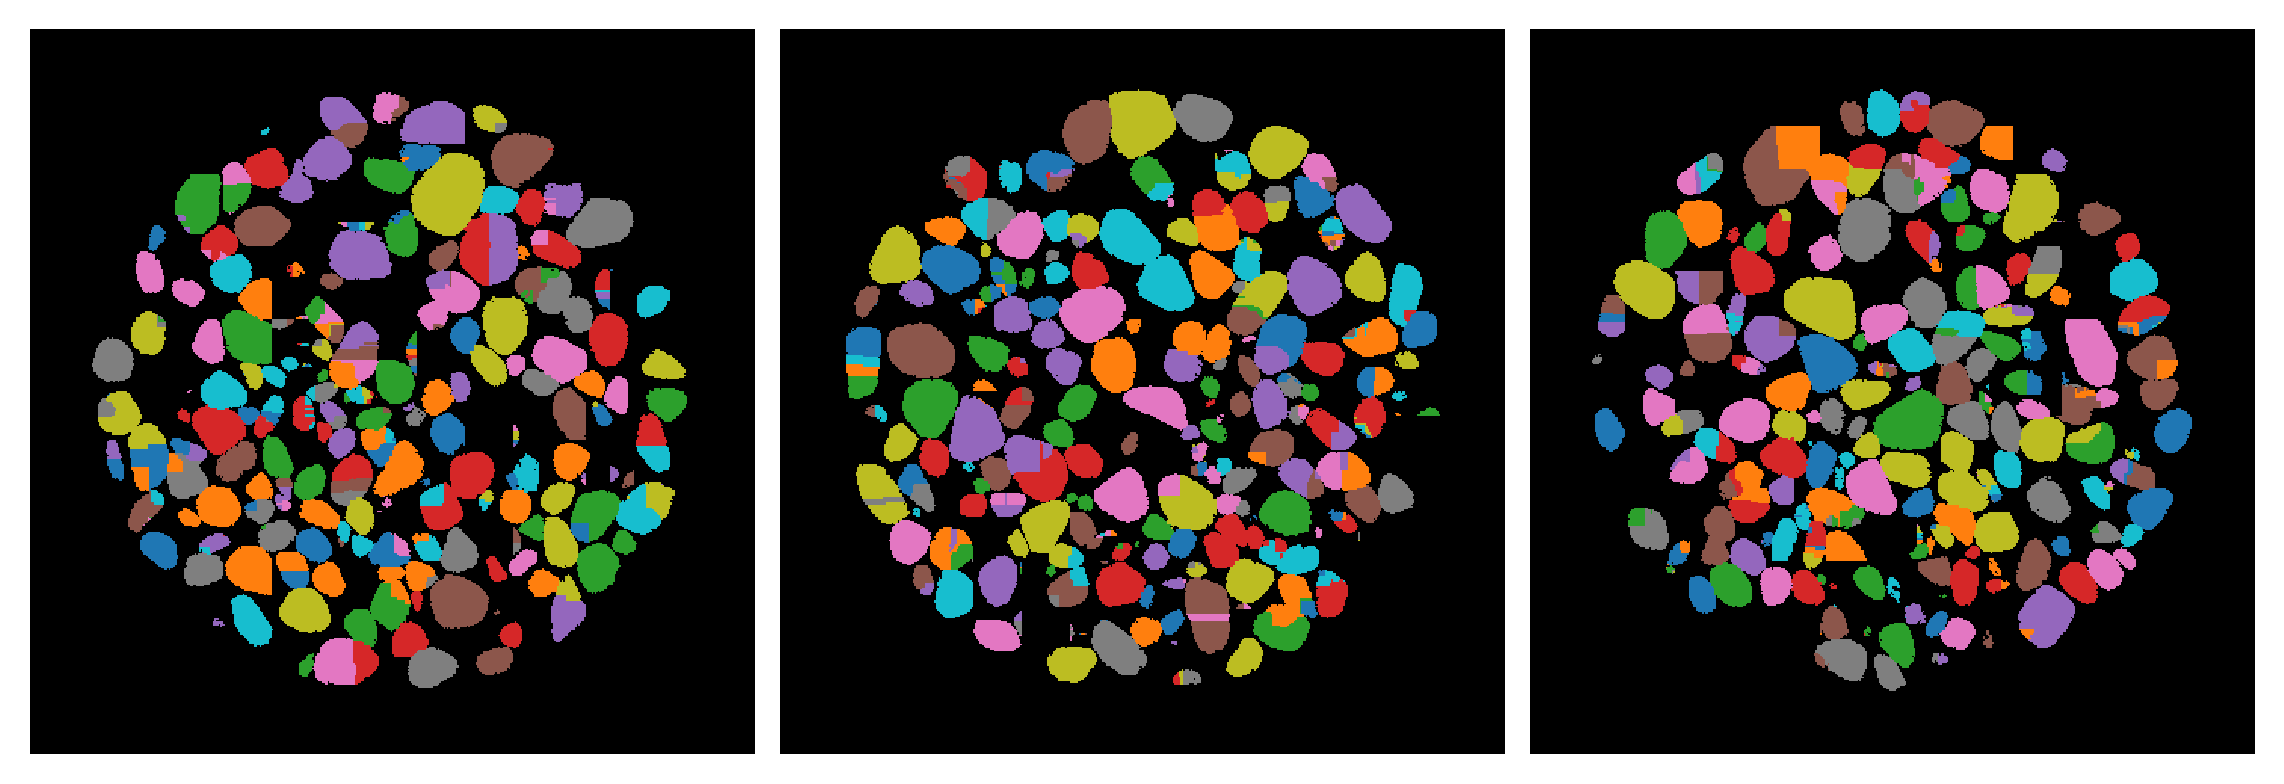

Minimum peak distance: 3
CT resolution: 9.199575
Minimum peak distance (um): 27.598724999999998
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


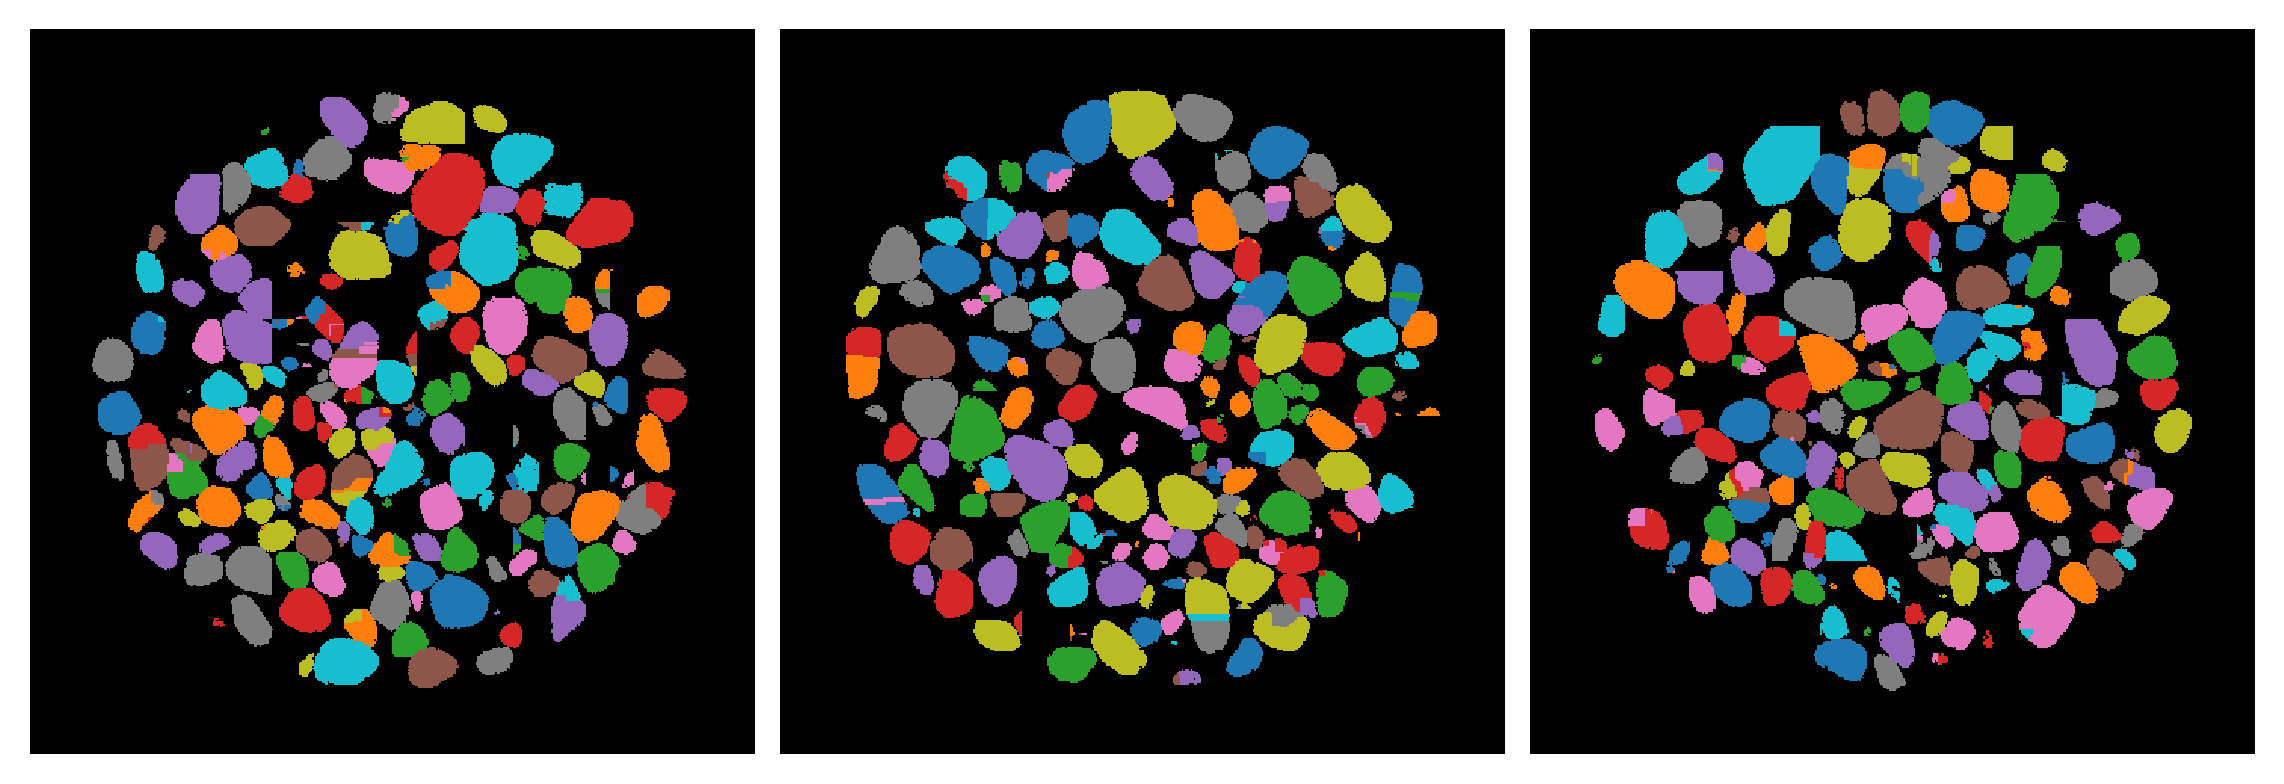

Minimum peak distance: 4
CT resolution: 9.199575
Minimum peak distance (um): 36.7983
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


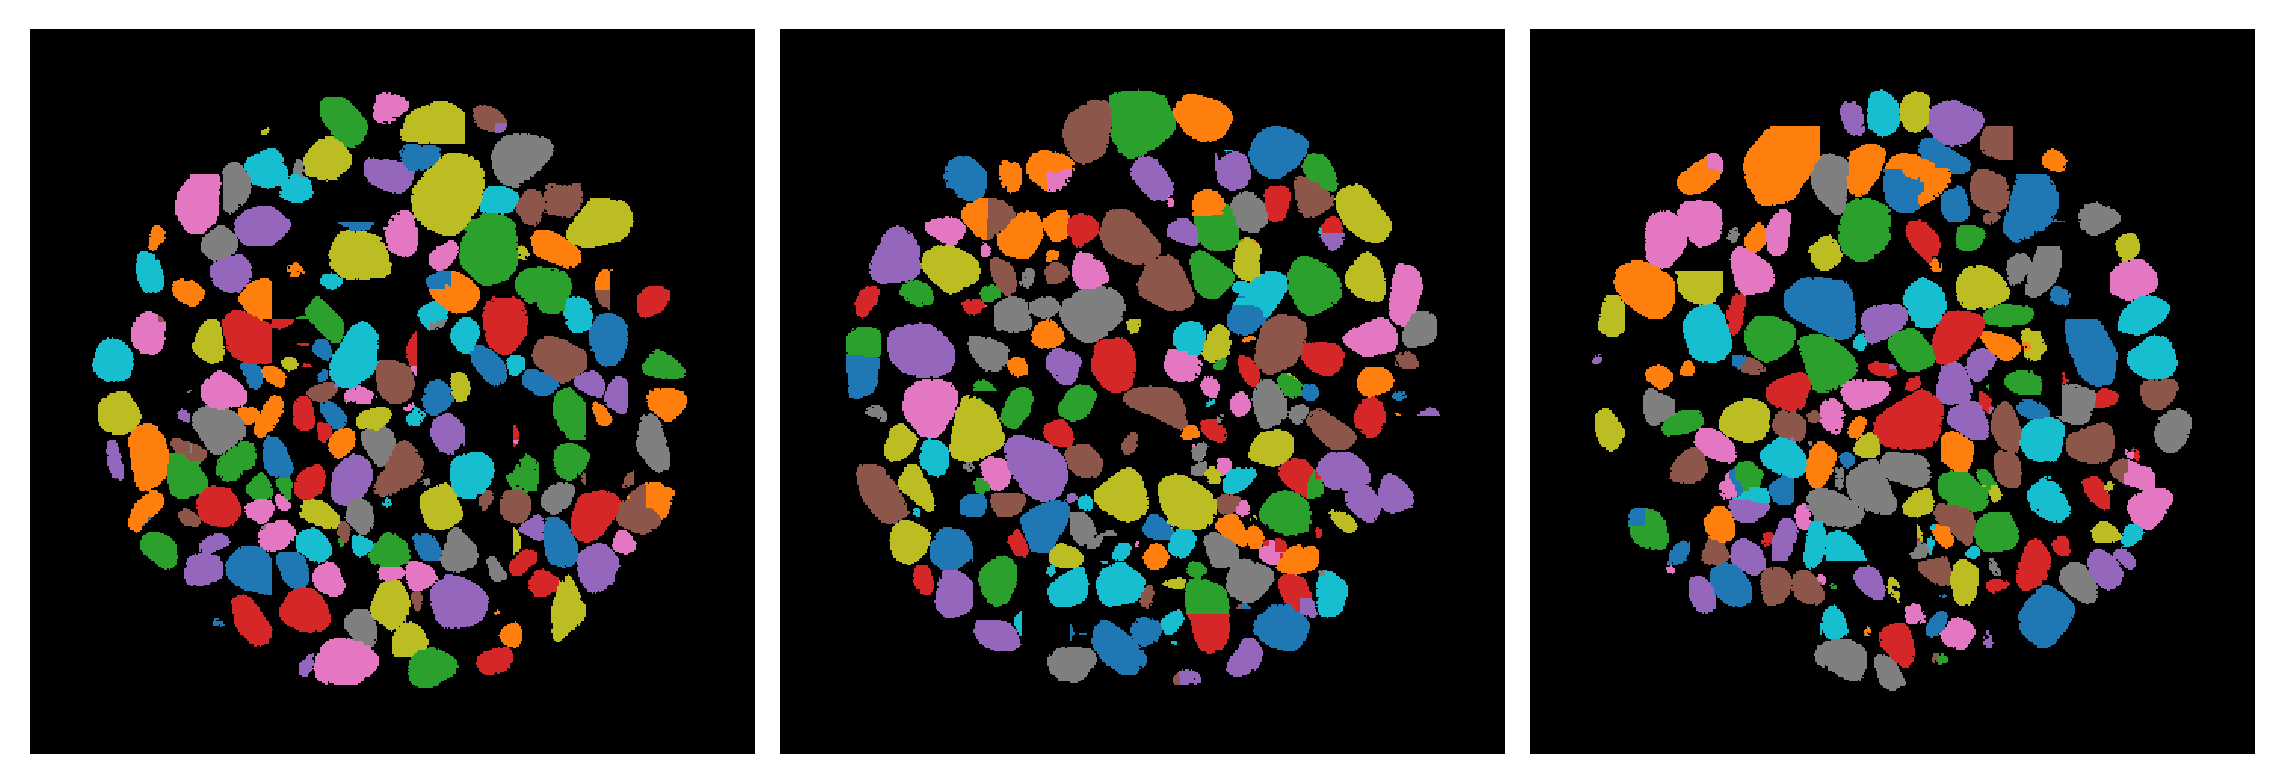

Minimum peak distance: 5
CT resolution: 9.199575
Minimum peak distance (um): 45.99787499999999
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


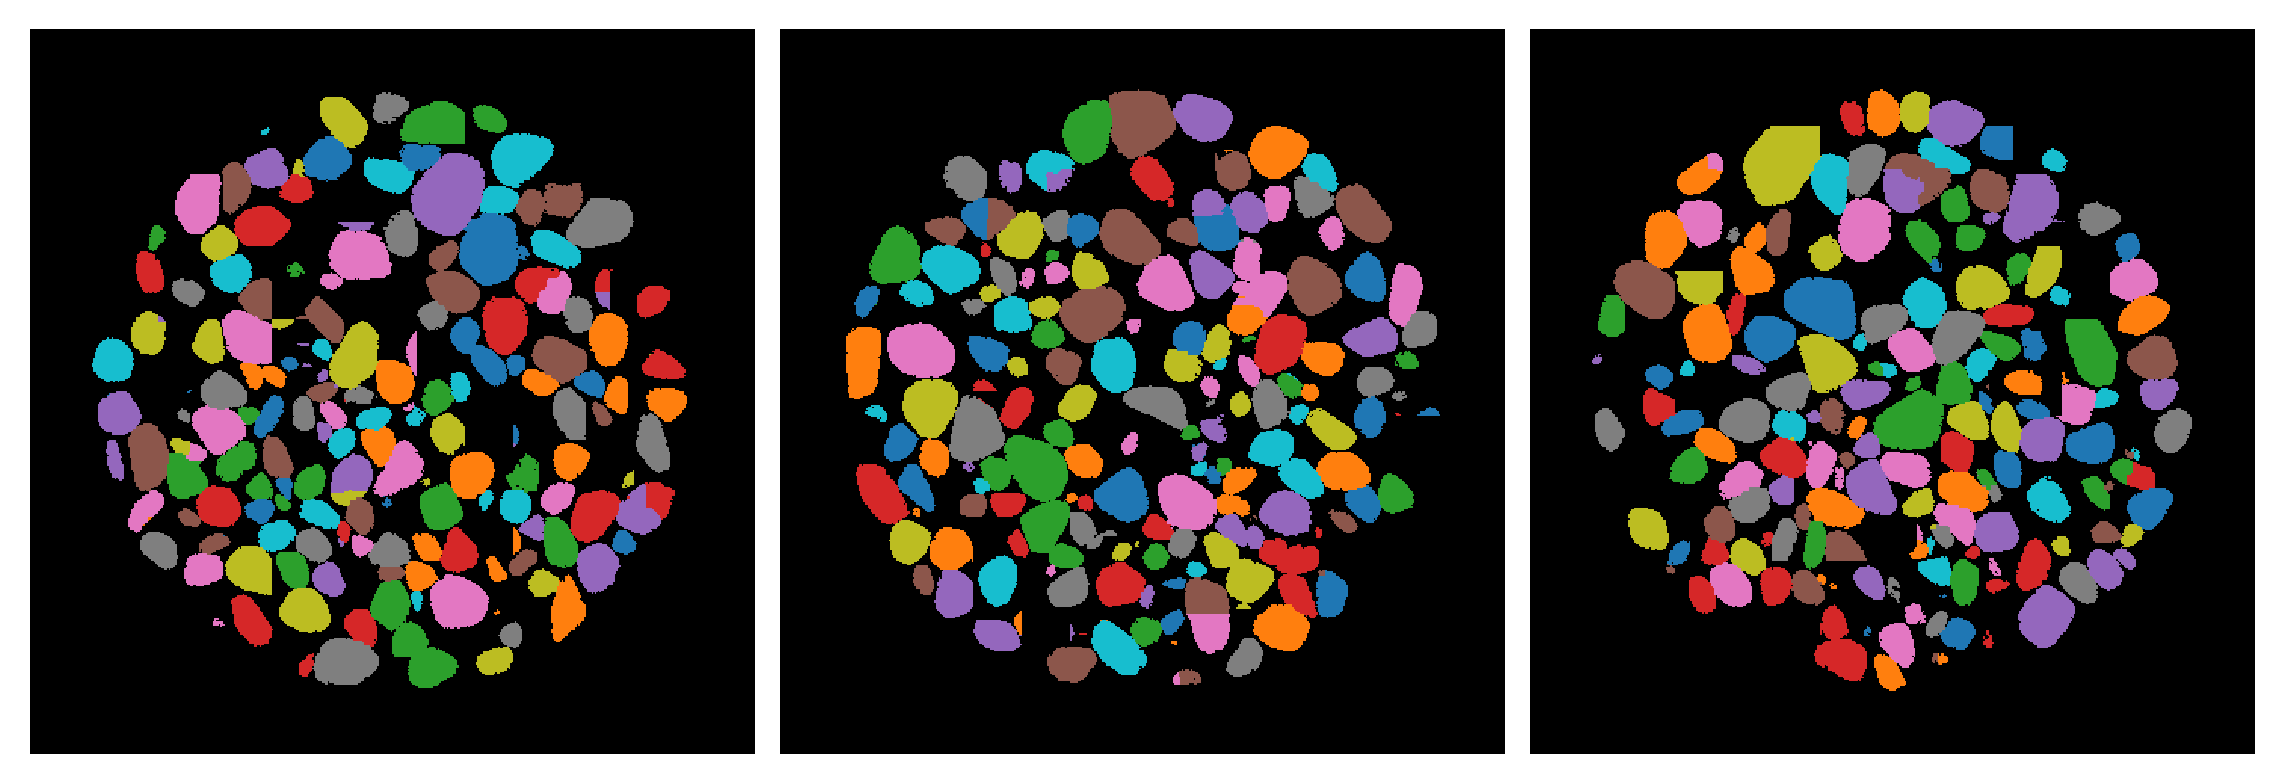

Minimum peak distance: 6
CT resolution: 9.199575
Minimum peak distance (um): 55.197449999999996
Loading images...
--> Images loaded as 3D array:  (320, 480, 480)


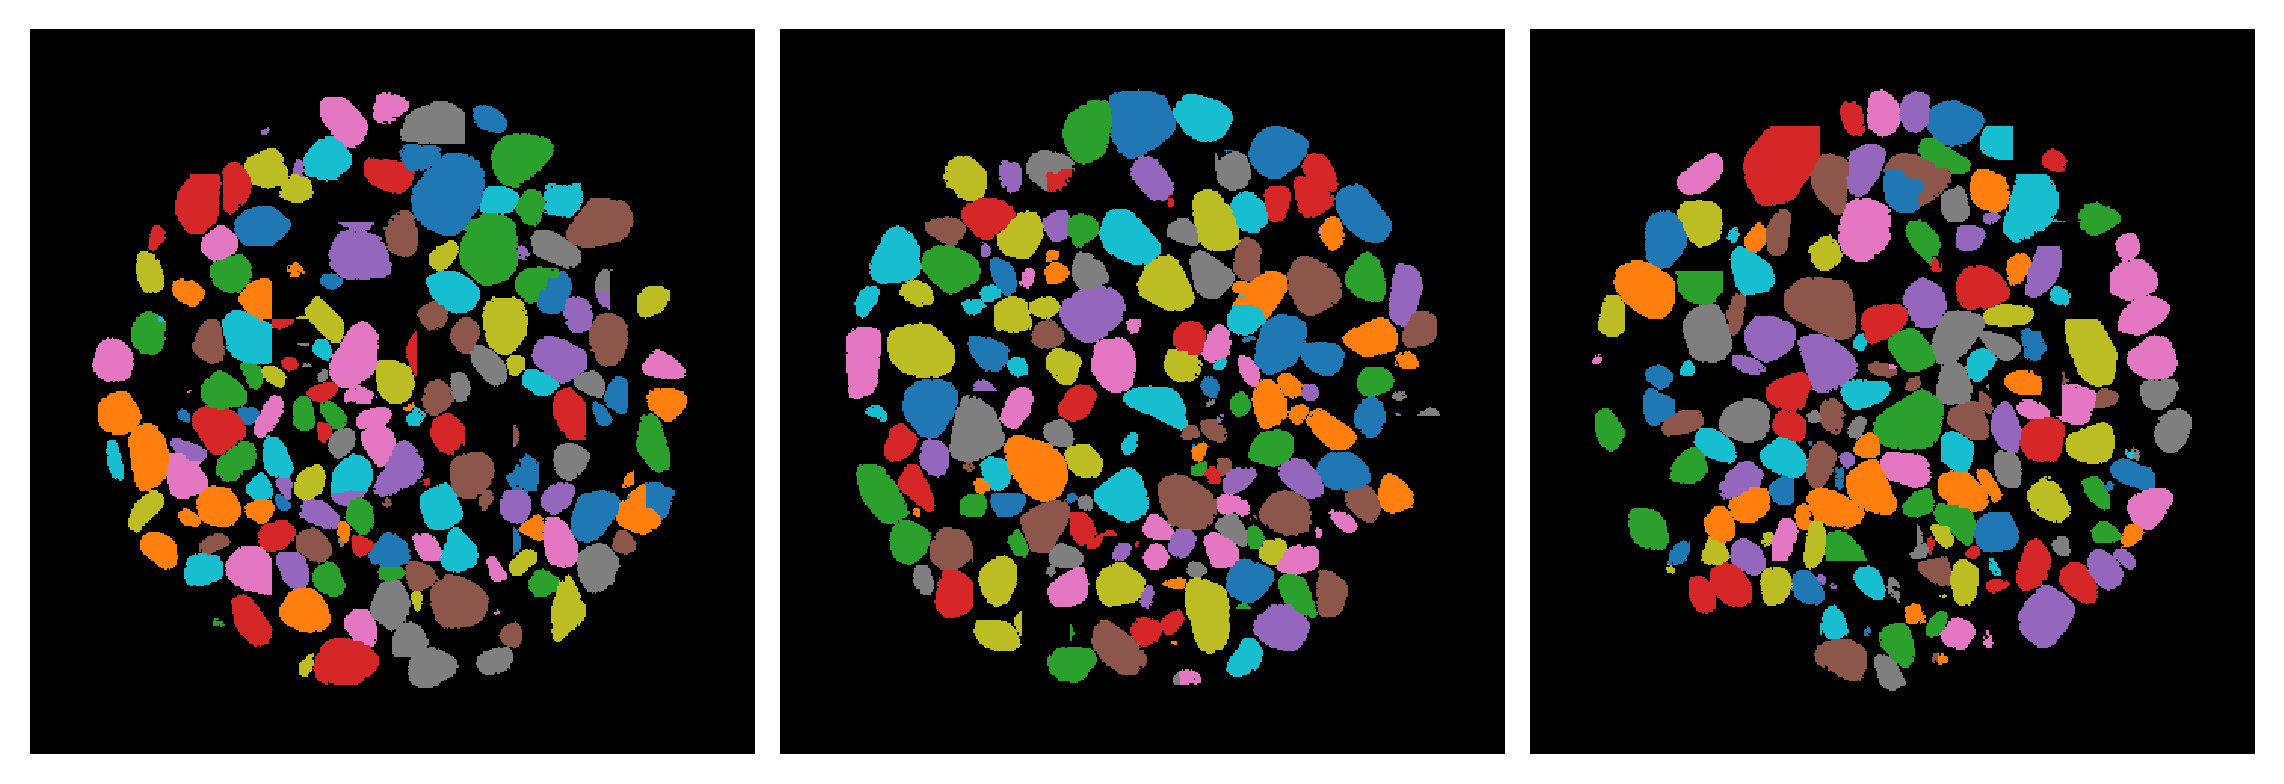

In [97]:
n_grid_voxels = 320
ct_res = 9.199575
for mpd in range(1, 7):
    print('Minimum peak distance:', mpd)
    print('CT resolution:', ct_res)
    print('Minimum peak distance (um):', mpd * ct_res)
    # img_dir_path = Path(
    #     f'segmentflow_output/output_{str(n_grid_voxels).zfill(3)}_{mpd}mpd'
    #     f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    img_dir_path = Path(
        f'C:/Users/cgusb/Research/PSAAP/alshibli_1551_study/'
        f'segmentflow_output/output_{str(n_grid_voxels).zfill(3)}_{mpd}mpd'
        f'/output_{str(n_grid_voxels).zfill(3)}_labeled_voxels')
    imgs_labeled = segment.load_images(img_dir_path, file_suffix='tif')
    fig, axes = view.plot_color_labels(
        imgs_labeled, nslices=3, exclude_bounding_slices=True, fig_w=7.5, dpi=300)
    # Based on IDOX "Full Production" doc
    # idox_bin_edges = np.array([0, 45, 75, 150, 300])
    # idox_standard = [33, 17, 0, 47.5]
    f50_bin_edges = [53,  75, 106, 150, 212, 300,  425, 600, 850]
    f50_standard =  [ 0, 0.2,   3,  15,  37,  34, 10.5, 0.3,   0]
    dims_df = get_dims_df(imgs_labeled)
    n_particles, sieve_sizes = simulate_sieve(
        dims_df, f50_bin_edges, pixel_res=ct_res)
    n_particles_dict[f'{n_grid_voxels}_{mpd}mpd'] = n_particles
    # fig, ax = grading_curve(
    #     n_particles, f50_bin_edges, standard_pct=stl0_cum_pct,
    #     standard_label='STL-0')
    plt.show()

[(0.267004, 0.004874, 0.329415, 1.0), (0.253935, 0.265254, 0.529983, 1.0), (0.163625, 0.471133, 0.558148, 1.0), (0.134692, 0.658636, 0.517649, 1.0), (0.477504, 0.821444, 0.318195, 1.0), (0.993248, 0.906157, 0.143936, 1.0)]
sieve_sizes=array([ 53,  75, 106, 150, 212, 300, 425, 600, 850])
standard_pct=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])


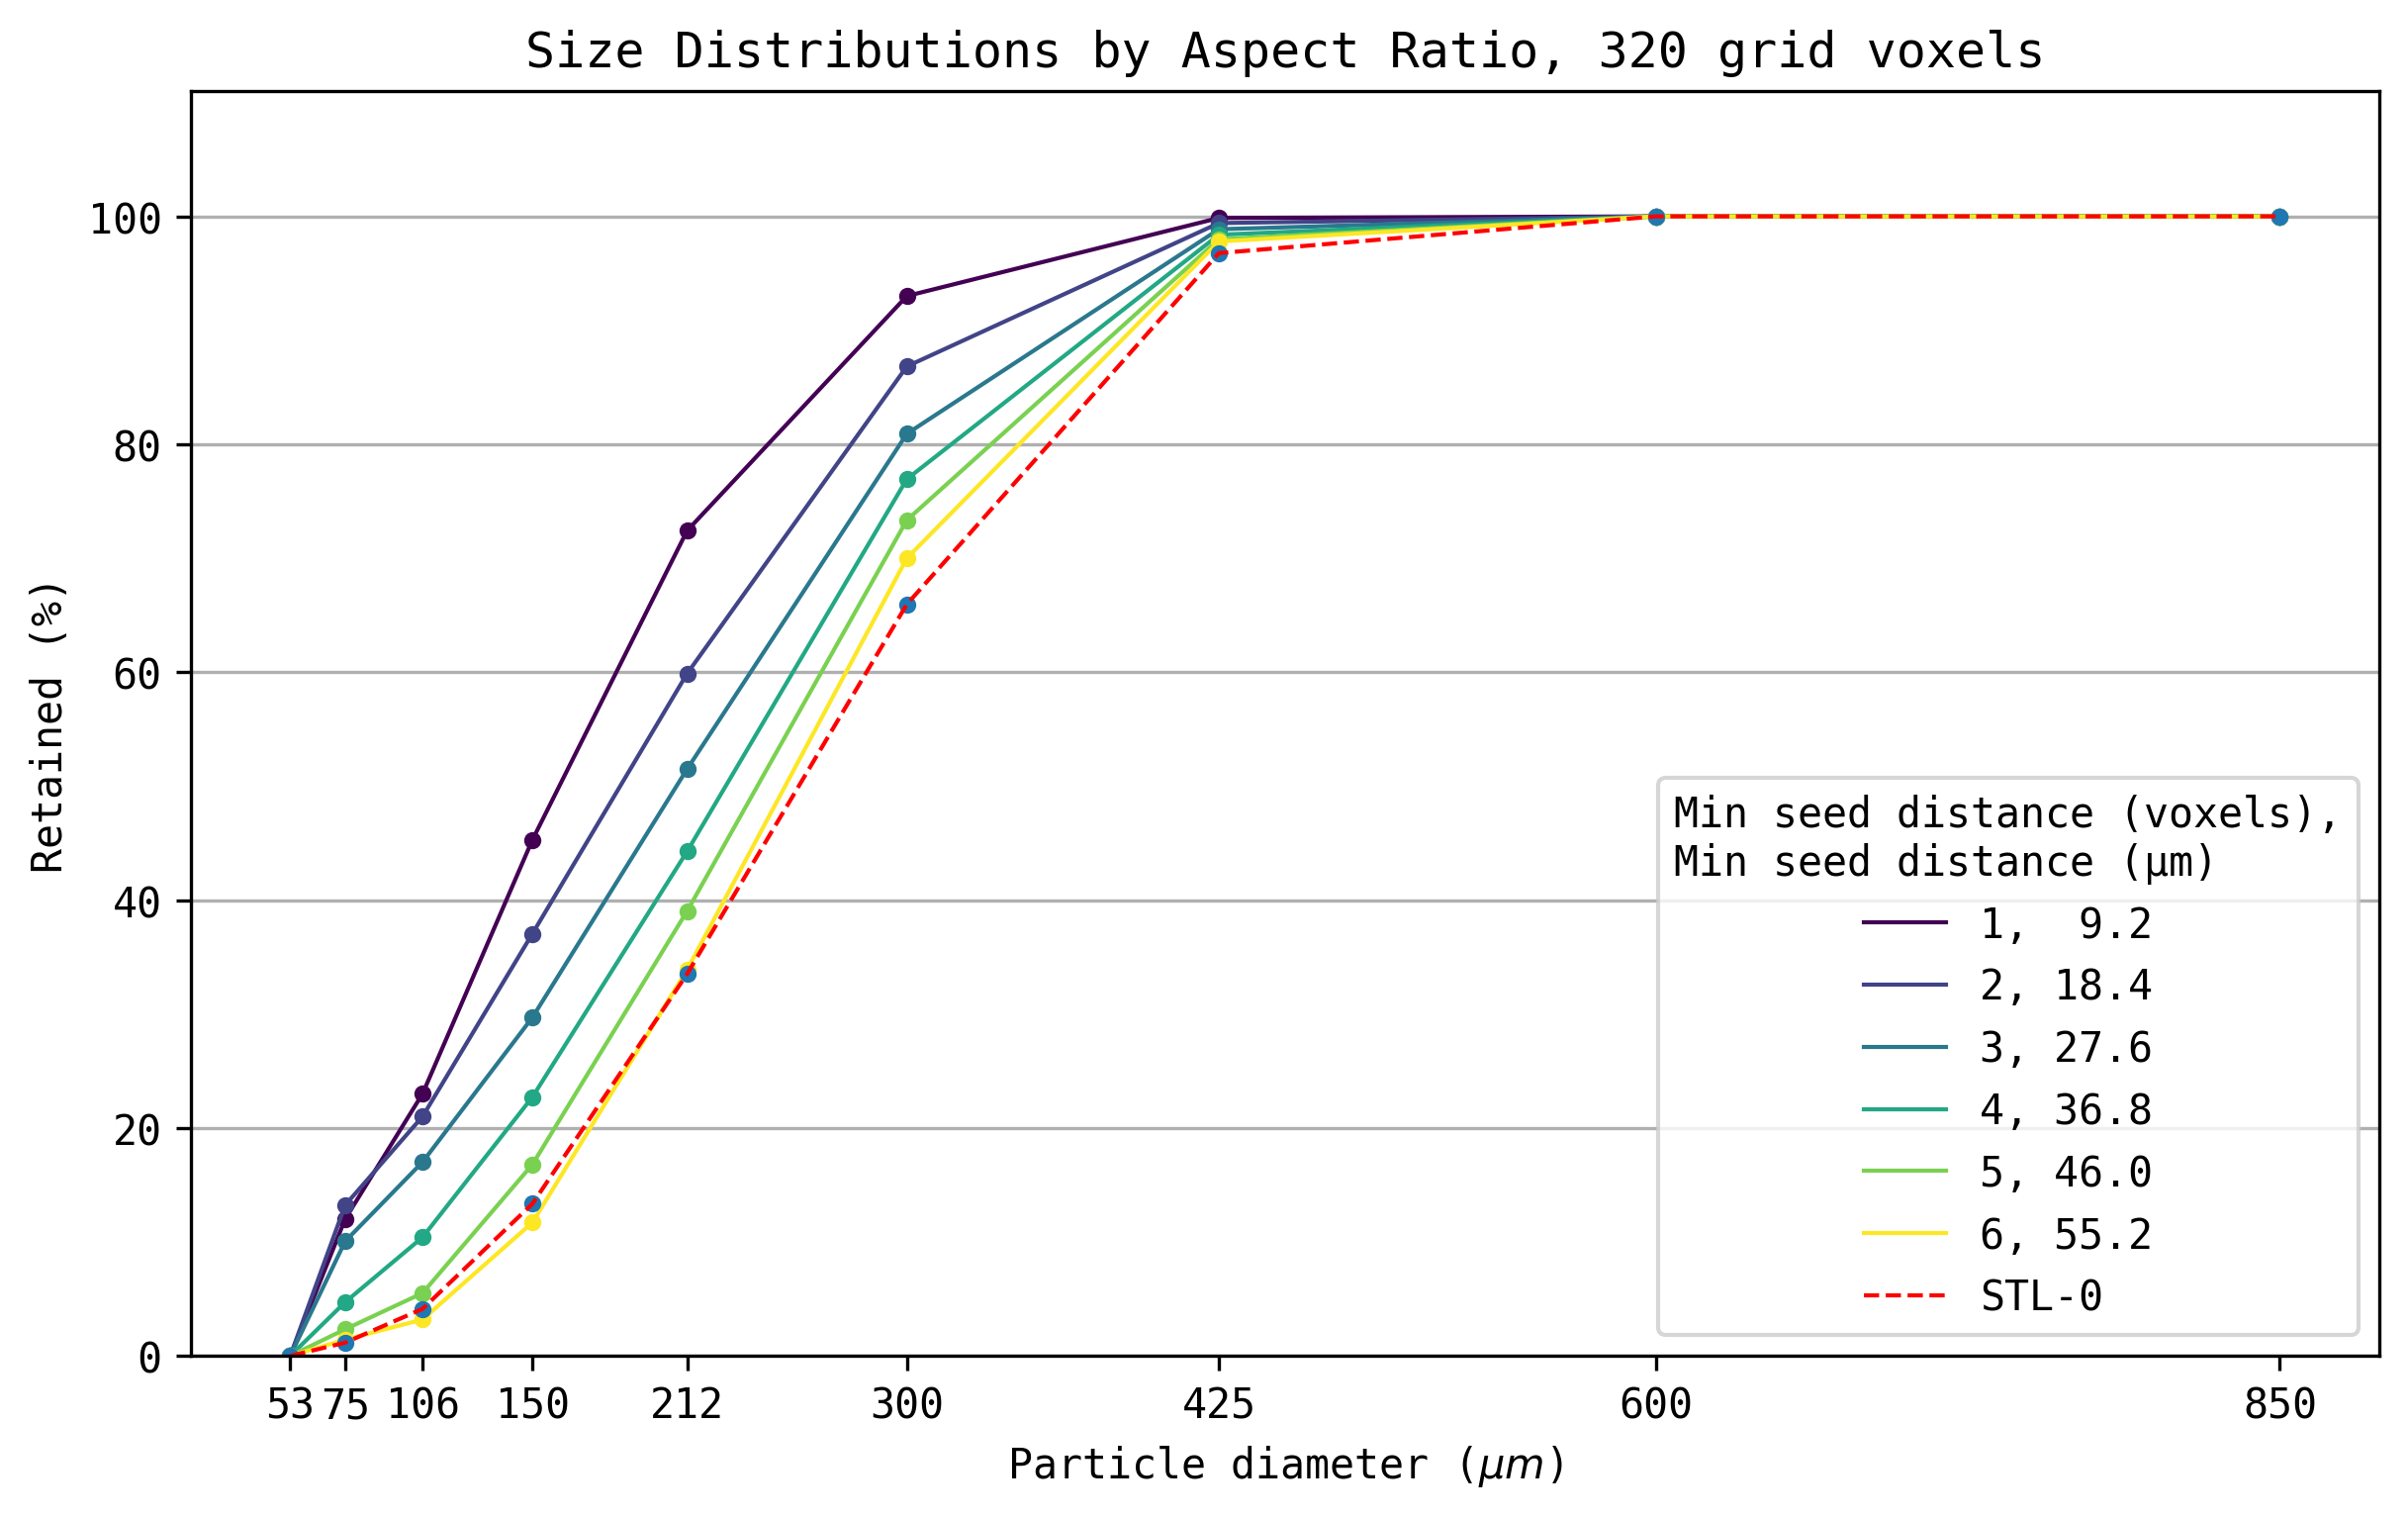

In [135]:
# Plot histogram
ct_res = 9.199575
to_plot = [
    '320_1mpd', '320_2mpd', '320_3mpd', '320_4mpd', '320_5mpd', '320_6mpd']
cmap = plt.get_cmap('viridis', len(to_plot))
print([cmap(i) for i in range(len(to_plot))])
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
i = 0
for label, n_particles in n_particles_dict.items():
    if label in to_plot:
        mpd = int(label[4])
        mpd_ums = mpd * ct_res
        n_particles = np.insert(n_particles, 0, 0)
        pct_particles = 100 * n_particles / np.sum(n_particles)
        ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2, color=cmap(i))
        ax.plot(
            sieve_sizes, np.cumsum(pct_particles),
            label=f'{mpd}, {round(mpd_ums, 1): >4}',
            linewidth=1, zorder=2, color=cmap(i)
        )
        i += 1
standard_pct = np.insert(stl0_cum_pct, 0, 0)
print(f'{sieve_sizes=}')
print(f'{standard_pct=}')
ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
ax.plot(
    sieve_sizes, standard_pct, label='STL-0',
    linewidth=1, zorder=2, color='red', linestyle='--'
)
ax.set_title('Size Distributions by Aspect Ratio, 320 grid voxels')
ax.set_ylabel(r'Retained (%)')
ax.set_ylim([0, 111])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(sieve_sizes)
ax.set_xticklabels(sieve_sizes)
ax.legend(title='Min seed distance (voxels),\nMin seed distance (µm)')
plt.show()

## Plot together

In [86]:
list(n_particles_dict.keys())

[10,
 20,
 40,
 80,
 '160_1mpd',
 '160_2mpd',
 '160_3mpd',
 '320_1mpd',
 '320_2mpd',
 '320_3mpd',
 '320_4mpd',
 '320_5mpd',
 '320_6mpd']

sieve_sizes=array([ 53,  75, 106, 150, 212, 300, 425, 600, 850])
standard_pct=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])


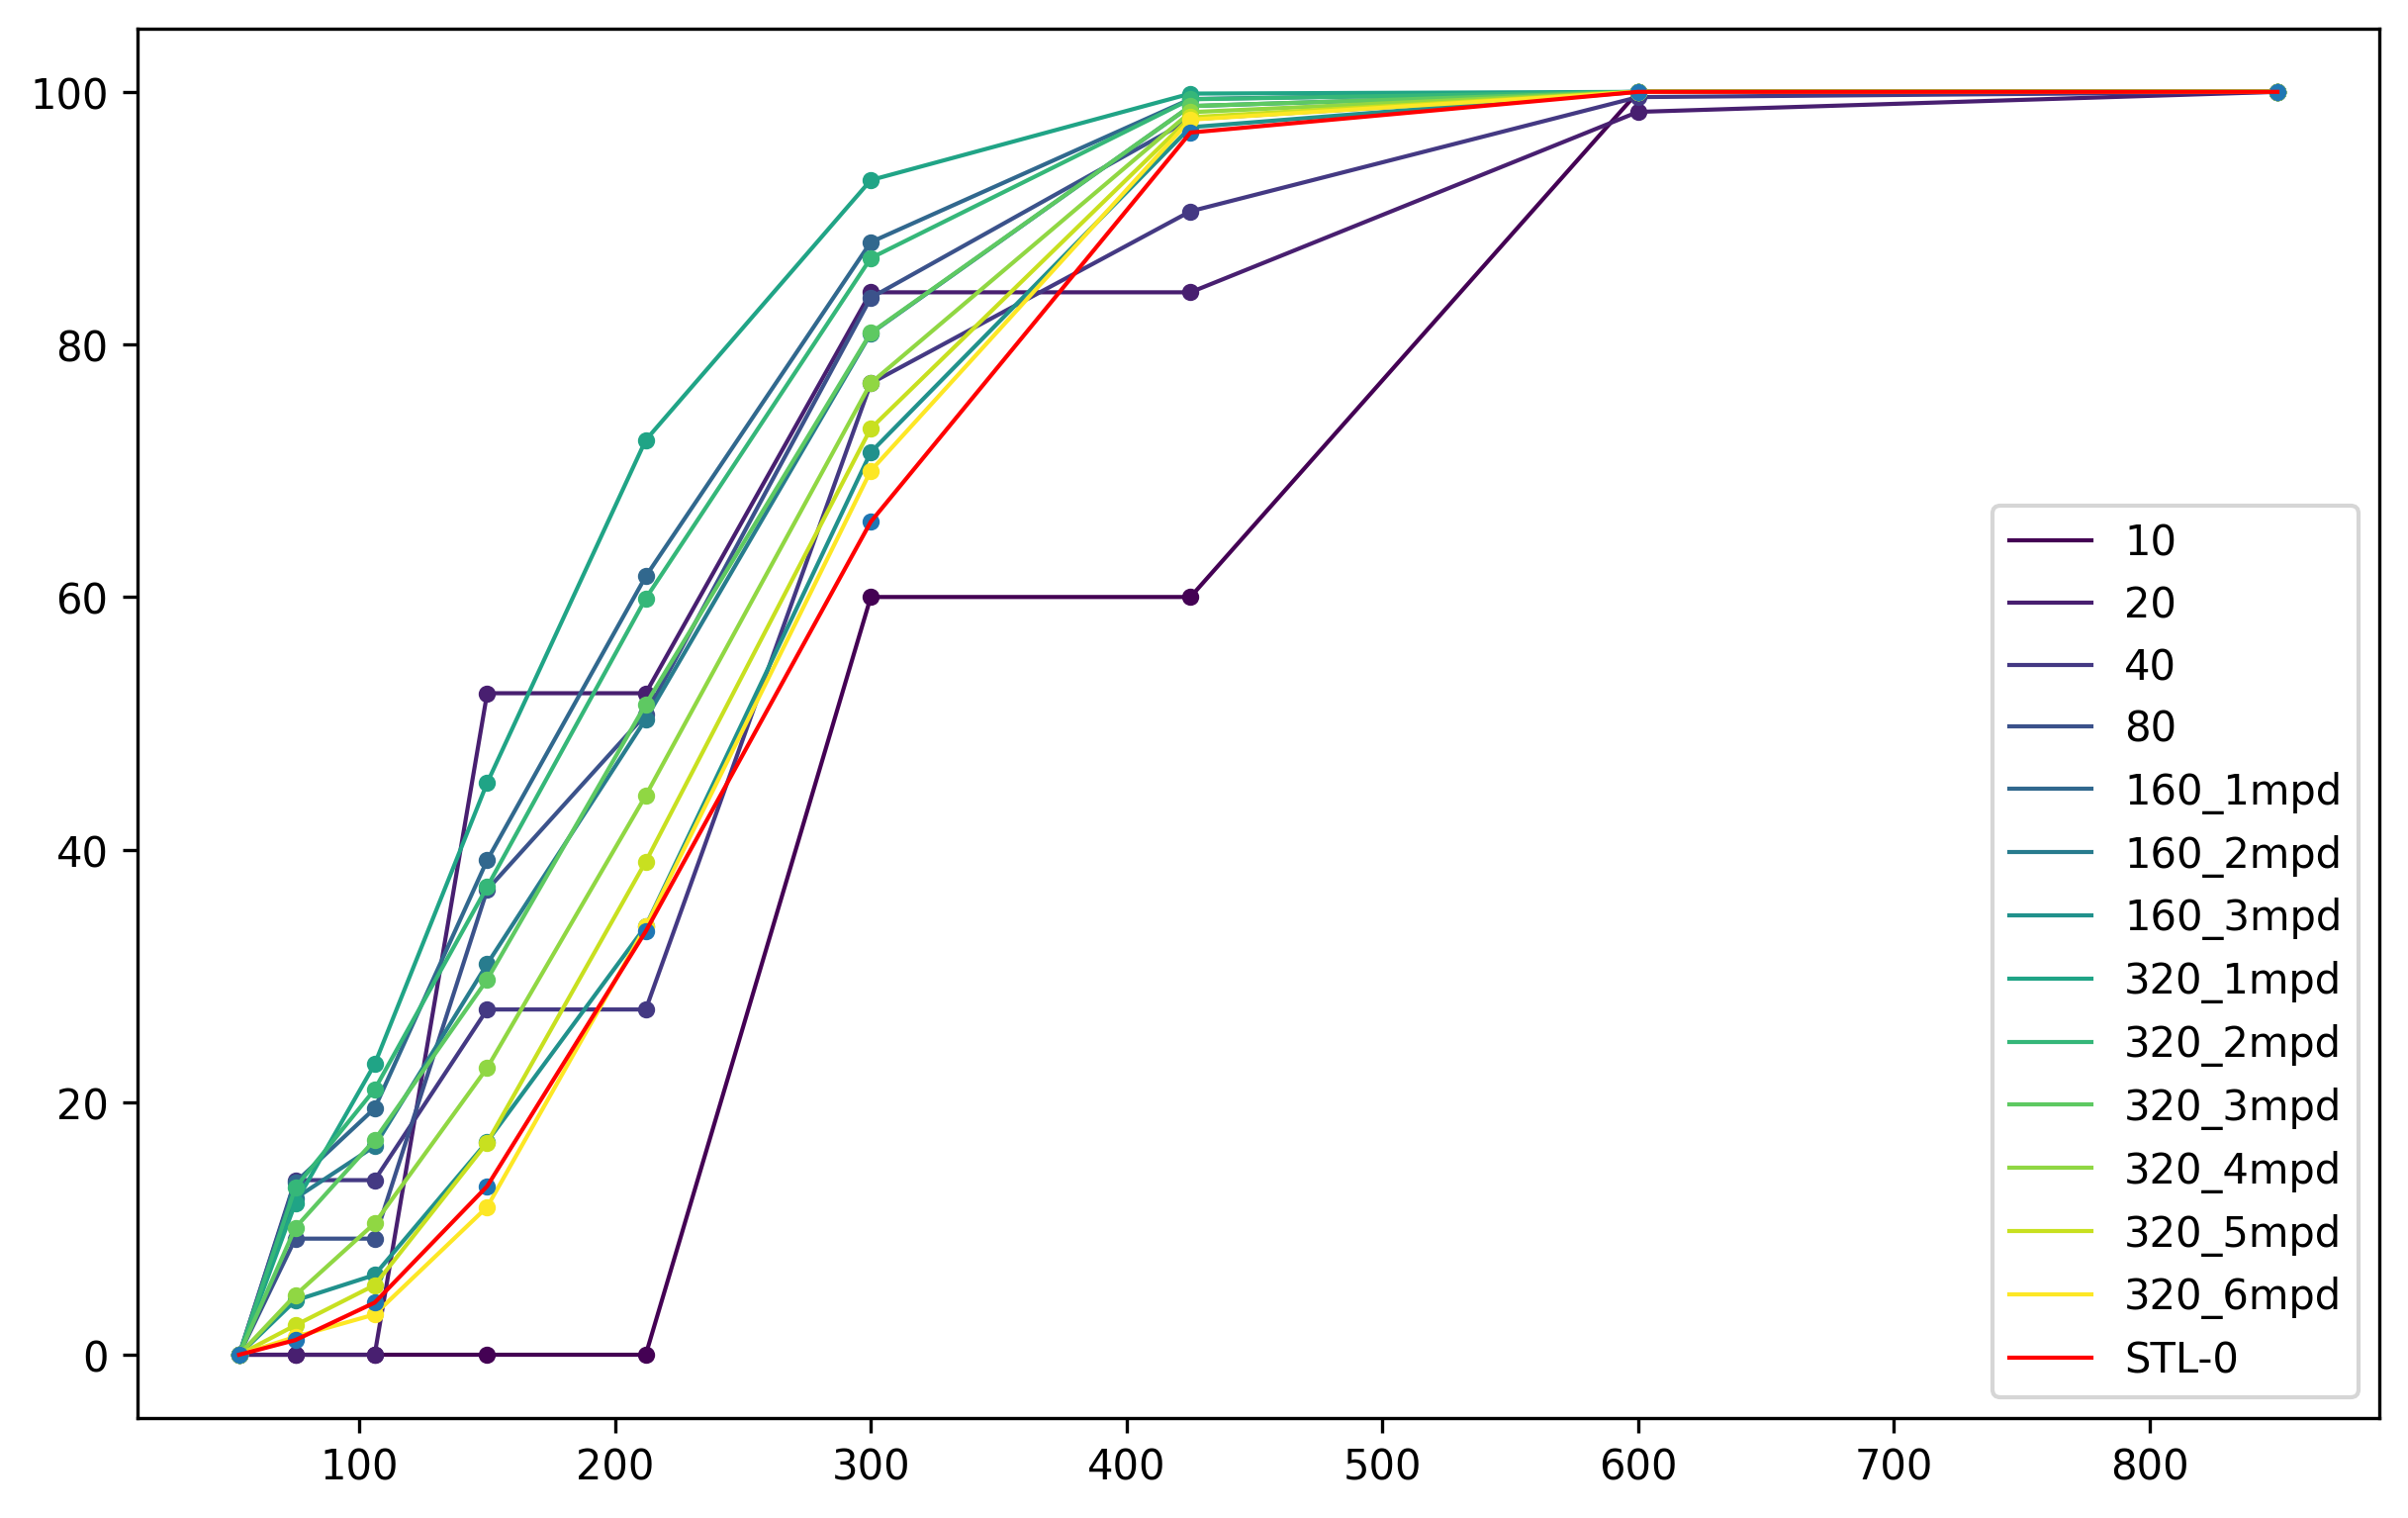

In [99]:
# Plot histogram
cmap = plt.get_cmap('viridis', len(n_particles_dict))
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
for i, (label, n_particles) in enumerate(n_particles_dict.items()):
    n_particles = np.insert(n_particles, 0, 0)
    pct_particles = 100 * n_particles / np.sum(n_particles)
    ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2, color=cmap(i))
    ax.plot(
        sieve_sizes, np.cumsum(pct_particles), label=label,
        linewidth=1, zorder=2, color=cmap(i)
    )
standard_pct = np.insert(stl0_cum_pct, 0, 0)
print(f'{sieve_sizes=}')
print(f'{standard_pct=}')
ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
ax.plot(
    sieve_sizes, standard_pct, label='STL-0',
    linewidth=1, zorder=2, color='red'
)
ax.legend()
plt.show()

sieve_sizes=array([ 53,  75, 106, 150, 212, 300, 425, 600, 850])
standard_pct=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])


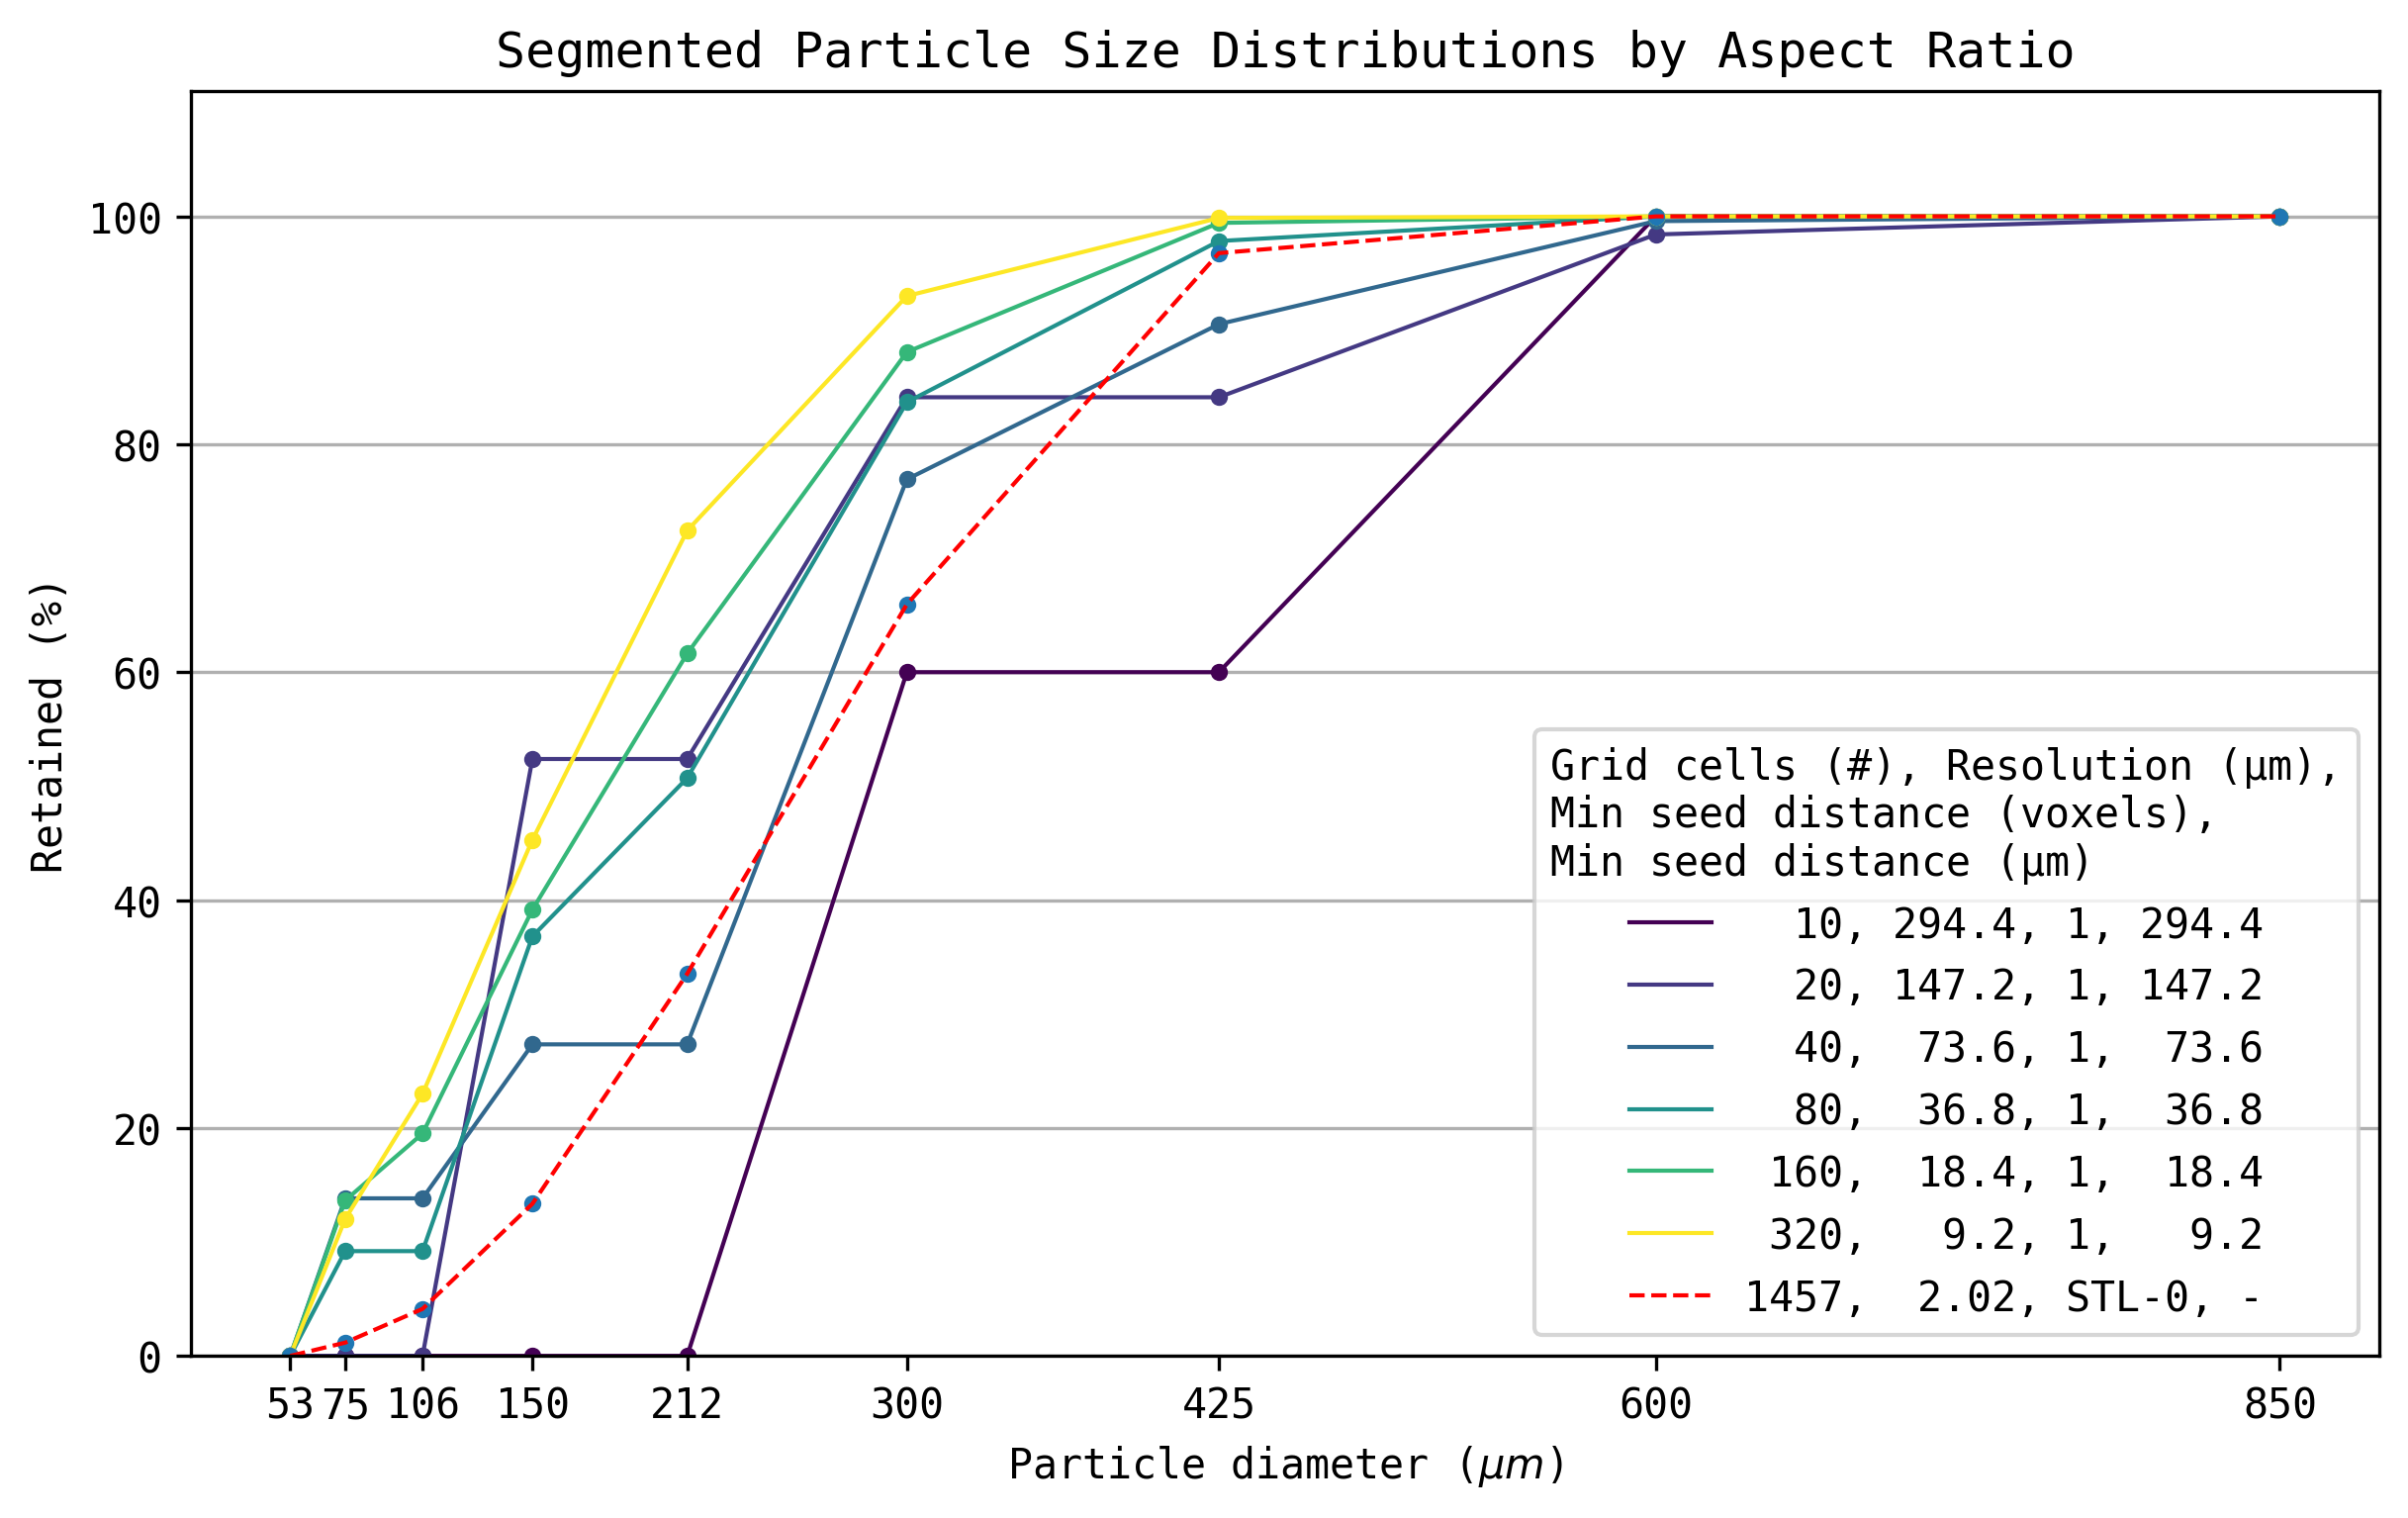

In [141]:
# Plot histogram
to_plot = [10, 20, 40, 60, 80, '160_1mpd', '320_1mpd']
cmap = plt.get_cmap('viridis', len(to_plot))
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
for i, (label, n_particles) in enumerate(n_particles_dict.items()):
    if label in to_plot:
        if isinstance(label, str):
            n_grid_voxels = int(label[:3])
            ct_res = round(resolutions[n_grid_voxels], 1)
            mpd = int(label[4])
            mpd_ums = round(mpd * ct_res, 1)
        else:
            n_grid_voxels = label
            ct_res = round(resolutions[n_grid_voxels], 1)
            mpd = 1
            mpd_ums = ct_res
        n_particles = np.insert(n_particles, 0, 0)
        pct_particles = 100 * n_particles / np.sum(n_particles)
        ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2, color=cmap(i))
        ax.plot(
            sieve_sizes, np.cumsum(pct_particles),
            label=f'{n_grid_voxels: >4}, {str(ct_res): >5},'
                  f' {mpd}, {mpd_ums: >5}',
            linewidth=1, zorder=2, color=cmap(i)
        )
standard_pct = np.insert(stl0_cum_pct, 0, 0)
print(f'{sieve_sizes=}')
print(f'{standard_pct=}')
ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
ax.plot(
    sieve_sizes, standard_pct, label='1457,  2.02, STL-0, -',
    linewidth=1, zorder=2, color='red', linestyle='--'
)
ax.set_title('Segmented Particle Size Distributions by Aspect Ratio')
ax.set_ylabel(r'Retained (%)')
ax.set_ylim([0, 111])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(sieve_sizes)
ax.set_xticklabels(sieve_sizes)
ax.legend(
    title='Grid cells (#), Resolution (µm),\n'
          'Min seed distance (voxels),\nMin seed distance (µm)'
)
plt.show()

In [124]:
label=f'{n_grid_voxels: >16}, {str(ct_res).zfill(6)}, {mpd}, {mpd_ums}'.format()
print(label)

             320, 0009.2, 5, 46.0


sieve_sizes=array([ 53,  75, 106, 150, 212, 300, 425, 600, 850])
standard_pct=array([  0.        ,   1.16054159,   4.12637008,  13.34622824,
        33.52675693,  65.95744681,  96.77627337, 100.        ,
       100.        ])


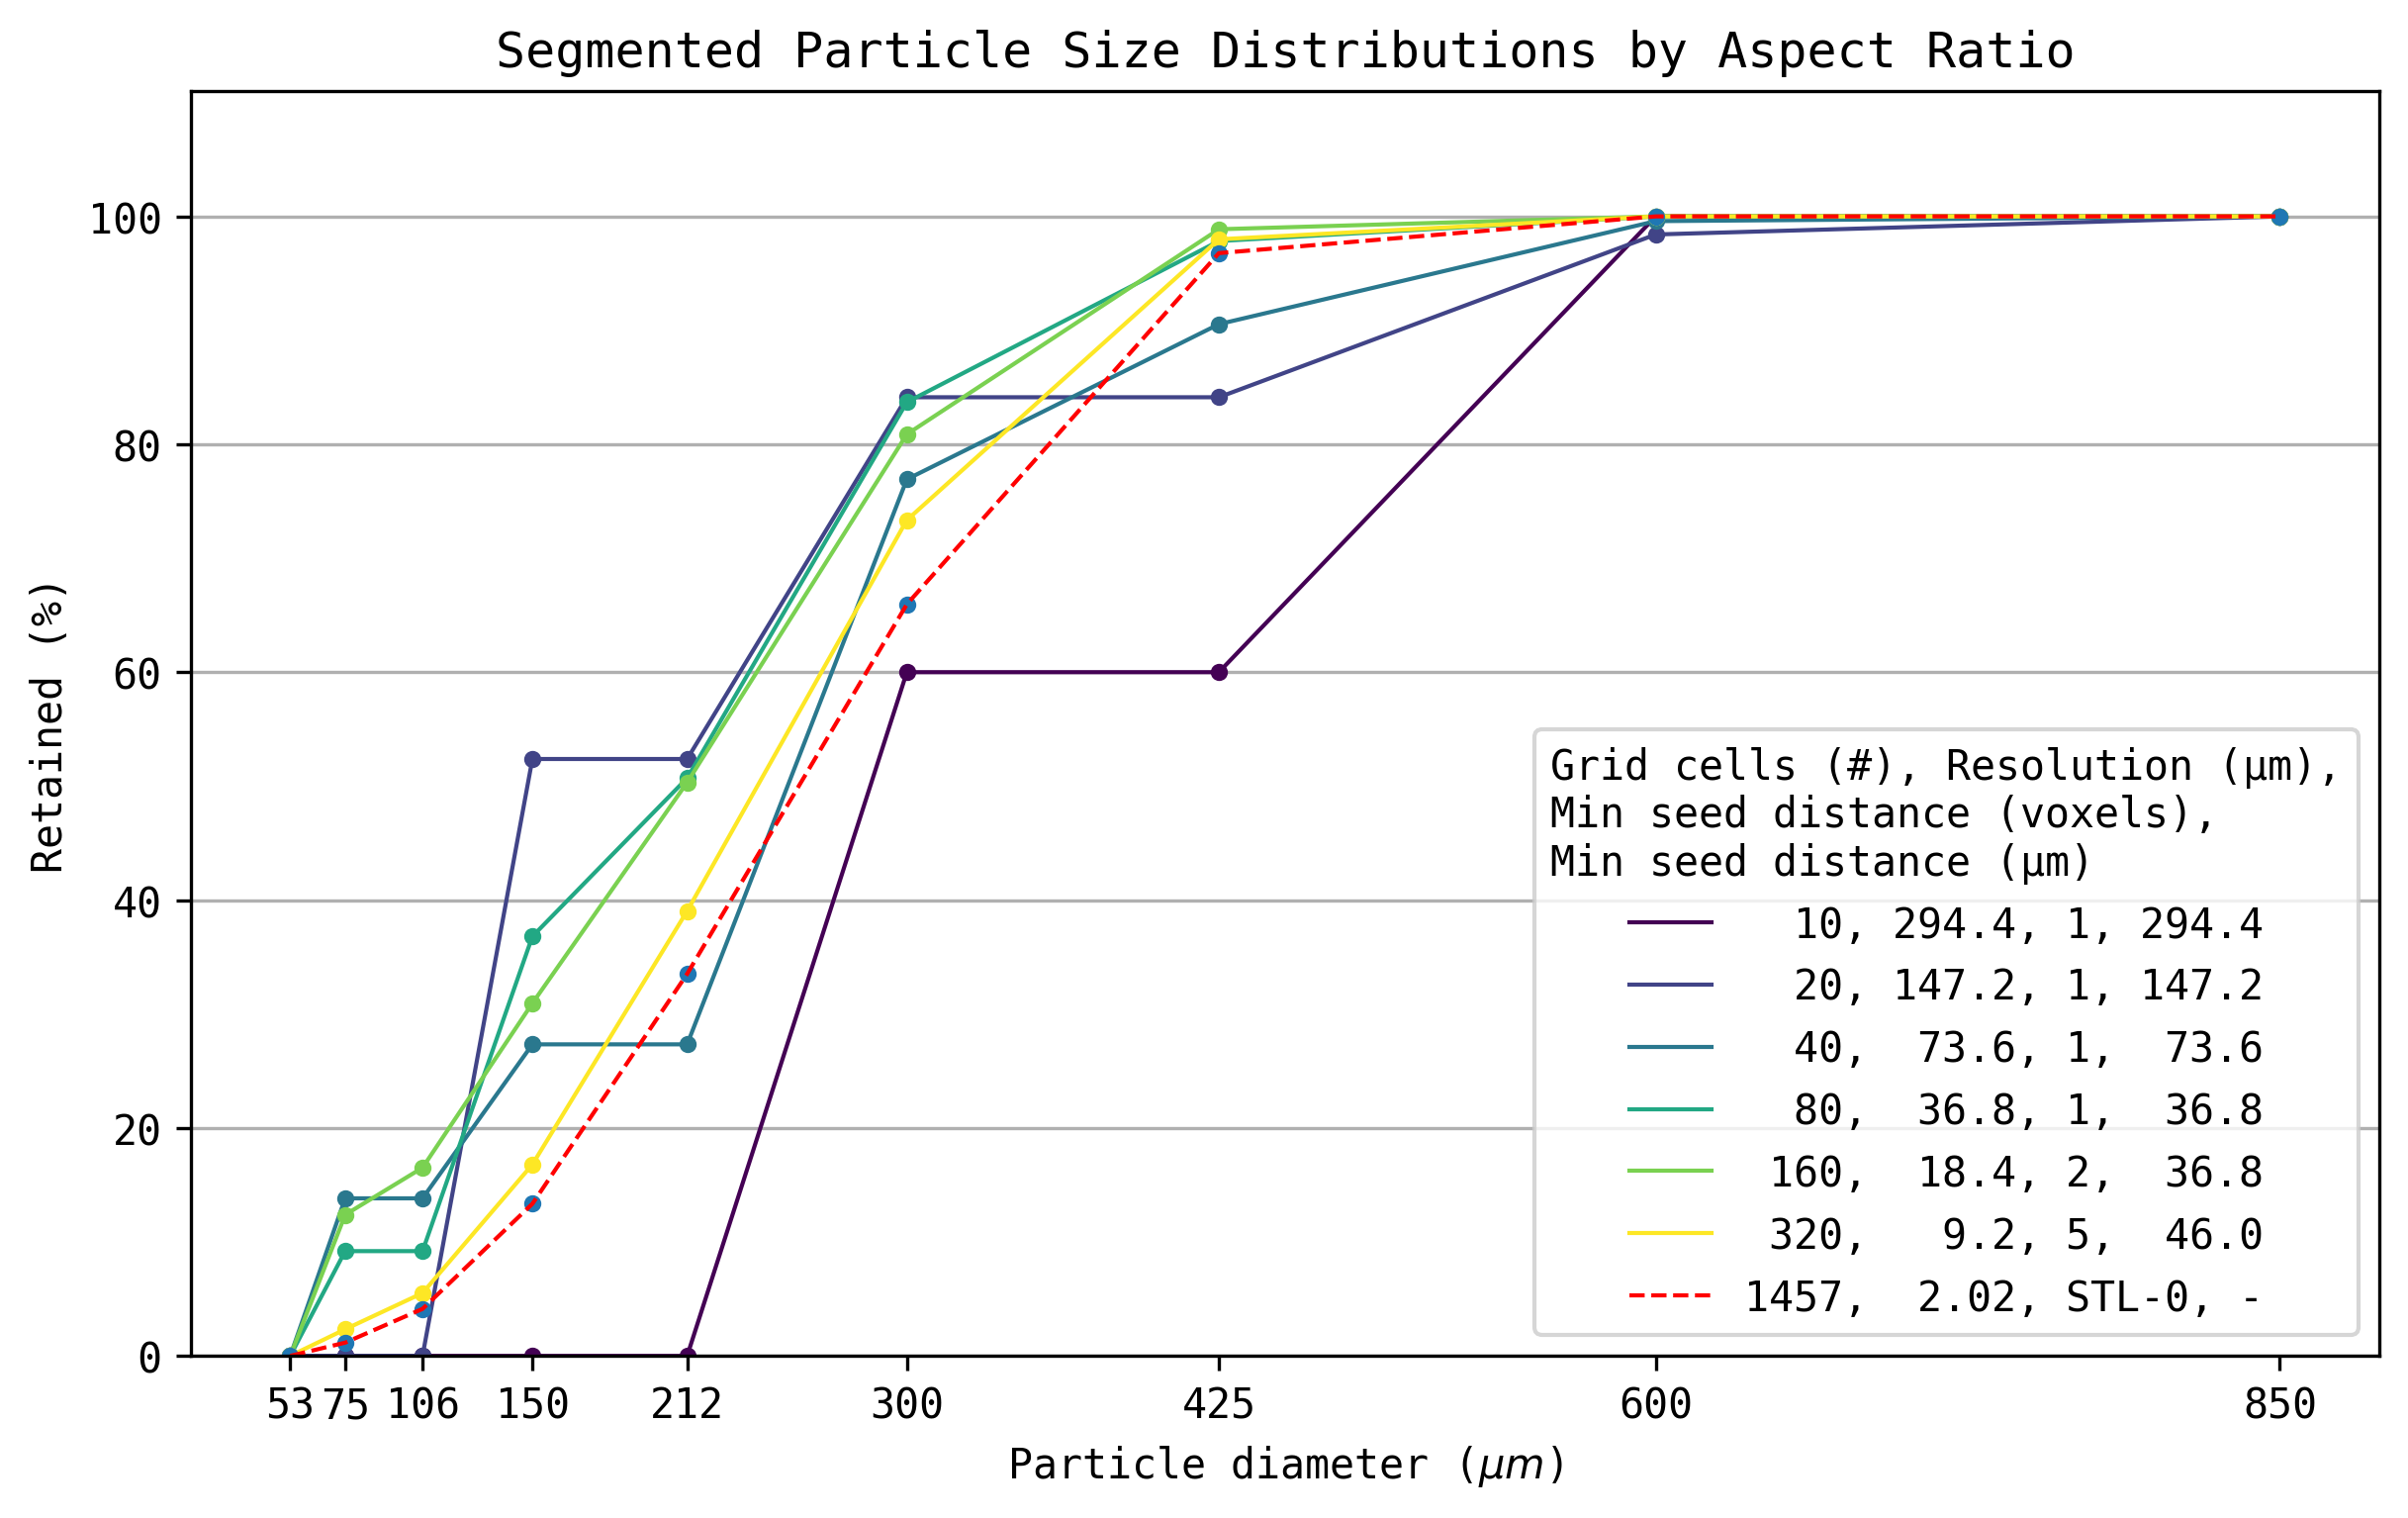

In [131]:
plt.rcParams["font.family"] = "monospace"
resolutions = {
    10  : 294.3864,
    20  : 147.1932,
    40  : 73.5966,
    80  : 36.7983,
    160 : 18.39915,
    320 : 9.199575,
}
# Plot histogram
to_plot = [10, 20, 40, 80, '160_2mpd', '320_5mpd']
cmap = plt.get_cmap('viridis', len(to_plot))
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
color_i = 0
for label, n_particles in n_particles_dict.items():
    if label in to_plot:
        if isinstance(label, str):
            n_grid_voxels = int(label[:3])
            ct_res = round(resolutions[n_grid_voxels], 1)
            mpd = int(label[4])
            mpd_ums = round(mpd * ct_res, 1)
        else:
            n_grid_voxels = label
            ct_res = round(resolutions[n_grid_voxels], 1)
            mpd = 1
            mpd_ums = ct_res
        n_particles = np.insert(n_particles, 0, 0)
        pct_particles = 100 * n_particles / np.sum(n_particles)
        ax.scatter(
            sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2,
            color=cmap(color_i))
        ax.plot(
            sieve_sizes, np.cumsum(pct_particles),
            label=f'{n_grid_voxels: >4}, {str(ct_res): >5},'
                  f' {mpd}, {mpd_ums: >5}',
            linewidth=1, zorder=2, color=cmap(color_i)
        )
        color_i += 1
standard_pct = np.insert(stl0_cum_pct, 0, 0)
print(f'{sieve_sizes=}')
print(f'{standard_pct=}')
ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
ax.plot(
    sieve_sizes, standard_pct, label='1457,  2.02, STL-0, -',
    linewidth=1, zorder=2, color='red', linestyle='--'
)
ax.set_title('Segmented Particle Size Distributions by Aspect Ratio')
ax.set_ylabel(r'Retained (%)')
ax.set_ylim([0, 111])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(sieve_sizes)
ax.set_xticklabels(sieve_sizes)
ax.legend(
    title='Grid cells (#), Resolution (µm),\n'
          'Min seed distance (voxels),\nMin seed distance (µm)'
)
plt.show()